Q1. Using the URDF file, determine the screw axes (Si ∈ R 6 or Bi ∈ R 6) of the robot joints when the robot is at its home/zero configuration. Note that a fixed space frame {s} is attached to the robot base, and a body frame {b} is attached to the robot end-effector. To have a better understanding of the pose of the robot axes at its home/zero configuration, import the URDF file into Python using the function load urdf in pytransform3d package (Fig. 1). For more details, refer to the sample code in the folder assigned to your group.

In [21]:
import numpy as np
from scipy.spatial.transform import Rotation

joints_data = [
    {
        'name': 'joint1',
        'parent': 'link_base',
        'child': 'link1',
        'origin': [0, 0, 0.267],
        'rpy': [0, 0, 0],
        'axis': [0, 0, 1]  
    },
    {
        'name': 'joint2',
        'parent': 'link1',
        'child': 'link2',
        'origin': [0, 0, 0],
        'rpy': [-1.5708, 0, 0],  
        'axis': [0, 0, 1]
    },
    {
        'name': 'joint3',
        'parent': 'link2',
        'child': 'link3',
        'origin': [0, -0.293, 0],
        'rpy': [1.5708, 0, 0],
        'axis': [0, 0, 1]
    },
    {
        'name': 'joint4',
        'parent': 'link3',
        'child': 'link4',
        'origin': [0.0525, 0, 0],
        'rpy': [1.5708, 0, 0], 
        'axis': [0, 0, 1]
    },
    {
        'name': 'joint5',
        'parent': 'link4',
        'child': 'link5',
        'origin': [0.0775, -0.3425, 0],
        'rpy': [1.5708, 0, 0], 
        'axis': [0, 0, 1]
    },
    {
        'name': 'joint6',
        'parent': 'link5',
        'child': 'link6',
        'origin': [0, 0, 0],
        'rpy': [1.5708, 0, 0],  
        'axis': [0, 0, 1]
    },
    {
        'name': 'joint7',
        'parent': 'link6',
        'child': 'link7',
        'origin': [0.076, 0.097, 0],
        'rpy': [-1.5708, 0, 0],  
        'axis': [0, 0, 1]
    }
]

def rpy_to_rotation_matrix(rpy):
    r = Rotation.from_euler('xyz', rpy)
    return r.as_matrix()

def transformation_matrix(origin, rpy):
    T = np.eye(4)
    T[:3, :3] = rpy_to_rotation_matrix(rpy)
    T[:3, 3] = origin
    return T

def skew_symmetric(v):
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def compute_screw_axis(omega, q):
    
    omega = np.array(omega)
    q = np.array(q)
    v = -np.cross(omega, q)
    return np.concatenate([v, omega])

def adjoint_transformation(T):
    R = T[:3, :3]
    p = T[:3, 3]
    Ad = np.zeros((6, 6))
    Ad[:3, :3] = R
    Ad[3:, 3:] = R
    Ad[:3, 3:] = skew_symmetric(p) @ R
    return Ad

# ============================================================================
# FORWARD KINEMATICS - COMPUTE JOINT FRAMES IN SPACE FRAME
# ============================================================================

T_current = np.eye(4)  
joint_transforms = []  

for i, joint in enumerate(joints_data):
    T_joint = transformation_matrix(joint['origin'], joint['rpy'])
    
    T_current = T_current @ T_joint
    joint_transforms.append(T_current.copy())


M = T_current.copy()

# ============================================================================
# SPACE FRAME SCREW AXES (Si)
# ============================================================================

space_screws = []

for i, (joint, T) in enumerate(zip(joints_data, joint_transforms)):
    # Local axis in joint frame
    axis_local = np.array(joint['axis'])
    
    # Transform axis to space frame using rotation part of T
    R = T[:3, :3]
    omega_s = R @ axis_local
    omega_s = omega_s / np.linalg.norm(omega_s) 
    
    # Position of joint origin in space frame
    q_s = T[:3, 3]
    
    # Compute screw axis
    S_i = compute_screw_axis(omega_s, q_s)
    space_screws.append(S_i)



# ============================================================================
# BODY FRAME SCREW AXES (Bi)
# ============================================================================

M_inv = np.linalg.inv(M)
Ad_M_inv = adjoint_transformation(M_inv)

body_screws = []

for i, S_i in enumerate(space_screws):
    B_i = Ad_M_inv @ S_i
    body_screws.append(B_i)

print("\nSPACE FRAME SCREW AXES (Si):")
for i, S in enumerate(space_screws):
    print(f"   S{i+1} = {S}")

print("\nBODY FRAME SCREW AXES (Bi):")
for i, B in enumerate(body_screws):
    print(f"   B{i+1} = {B}")



SPACE FRAME SCREW AXES (Si):
   S1 = [-0. -0. -0.  0.  0.  1.]
   S2 = [-0.267  0.    -0.     0.     1.    -0.   ]
   S3 = [ 0. -0. -0.  0.  0.  1.]
   S4 = [ 0.56    0.     -0.0525  0.     -1.     -0.    ]
   S5 = [-0.    0.13  0.    0.    0.   -1.  ]
   S6 = [-0.2175 -0.      0.13    0.      1.      0.    ]
   S7 = [-0.     0.206  0.     0.     0.    -1.   ]

BODY FRAME SCREW AXES (Bi):
   B1 = [-0.    -0.206  0.     0.    -0.    -1.   ]
   B2 = [-0.1465  0.      0.206   0.     -1.      0.    ]
   B3 = [-0.    -0.206  0.     0.    -0.    -1.   ]
   B4 = [ 0.4395 -0.     -0.1535  0.      1.     -0.    ]
   B5 = [ 0.     0.076  0.     0.    -0.     1.   ]
   B6 = [-0.097 -0.     0.076  0.    -1.    -0.   ]
   B7 = [ 0.  0.  0.  0. -0.  1.]


2. (1/10) In order to make sure that the screw axes are determined correctly, use your forward kinematics
function (FK SpaceForm or FK BodyForm from HW#5) to compute the end-effector configuration Tsb ∈
SE(3) for an arbitrary set of feasible joint angles θ ∈ R n (refer to the Specification file to find the joint limits), and then, use the function plot transform (refer to the sample code) to visually verify that the end-effector configuration Tsb coincides with the end-effector {b}-frame of the robot imported into Python at the same configuration θ.


FORWARD KINEMATICS VERIFICATION

Test 1: Home Configuration (all joints at 0)
--------------------------------------------------------------------------------
FK Space Form result:
[[ 1.      0.      0.      0.206 ]
 [ 0.     -1.      0.      0.    ]
 [ 0.     -0.     -1.      0.1205]
 [ 0.      0.      0.      1.    ]]

URDF FK result:
[[ 1.      0.      0.      0.206 ]
 [ 0.     -1.      0.      0.    ]
 [ 0.     -0.     -1.      0.1205]
 [ 0.      0.      0.      1.    ]]

Test 2: Random Feasible Configuration
--------------------------------------------------------------------------------
Joint angles (degrees): [-226.9048  112.7623  198.0956  210.7223  284.2757   68.6183  303.7494]

FK Space Form result:
[[-0.2214 -0.0777 -0.9721 -0.4491]
 [ 0.9702 -0.1183 -0.2115  0.291 ]
 [-0.0985 -0.9899  0.1016 -0.1676]
 [ 0.      0.      0.      1.    ]]

URDF FK result:
[[-0.2214 -0.0777 -0.9721 -0.4491]
 [ 0.9702 -0.1183 -0.2115  0.291 ]
 [-0.0985 -0.9899  0.1016 -0.1676]
 [ 0.      0.    

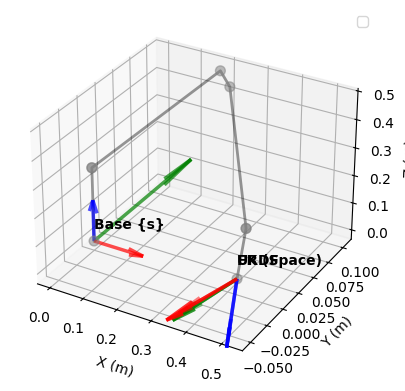

In [22]:

import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# JOINT LIMITS 
JOINT_LIMITS = {
    'joint1': (-2*np.pi, 2*np.pi),      # ±360°
    'joint2': (-2.059, 2.0944),          # -118° to 120°
    'joint3': (-2*np.pi, 2*np.pi),      # ±360°
    'joint4': (-0.19198, 3.927),         # -11° to 225°
    'joint5': (-2*np.pi, 2*np.pi),      # ±360°
    'joint6': (-1.69297, 3.14159265),    # -97° to 180°
    'joint7': (-2*np.pi, 2*np.pi)       # ±360°
}


def compute_space_screws():
    joints_data = [
        {'origin': [0, 0, 0.267], 'rpy': [0, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, -0.293, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0525, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0775, -0.3425, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.076, 0.097, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]}
    ]
    
    T_current = np.eye(4)
    space_screws = []
    
    for joint in joints_data:
        T_joint = transformation_matrix(joint['origin'], joint['rpy'])
        T_current = T_current @ T_joint
        

        R = T_current[:3, :3]
        omega_s = R @ np.array(joint['axis'])
        omega_s = omega_s / np.linalg.norm(omega_s)
        
        q_s = T_current[:3, 3]
        
        v_s = -np.cross(omega_s, q_s)
        S_i = np.concatenate([v_s, omega_s])
        space_screws.append(S_i)
    
    # Also return M
    M = T_current.copy()
    return np.column_stack(space_screws), M

# Compute screw axes and M
S_matrix, M = compute_space_screws()

# ============================================================================
# MATRIX EXPONENTIAL AND FORWARD KINEMATICS
# ============================================================================

def skew_symmetric(v):
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def screw_to_se3(S):

    v = S[:3]
    omega = S[3:]
    se3_matrix = np.zeros((4, 4))
    se3_matrix[:3, :3] = skew_symmetric(omega)
    se3_matrix[:3, 3] = v
    return se3_matrix

def matrix_exponential_se3(se3_matrix, theta):

    omega_hat = se3_matrix[:3, :3]
    v = se3_matrix[:3, 3]
    
    # Extract omega vector from skew-symmetric matrix
    omega = np.array([omega_hat[2, 1], omega_hat[0, 2], omega_hat[1, 0]])
    omega_norm = np.linalg.norm(omega)
    
    if omega_norm < 1e-6:  # Pure translation (prismatic joint)
        T = np.eye(4)
        T[:3, 3] = v * theta
        return T
    
    # Rodrigues' formula for rotation
    omega_hat_normalized = omega_hat / omega_norm
    theta_scaled = theta * omega_norm
    
    I = np.eye(3)
    R = I + np.sin(theta_scaled) * omega_hat_normalized + \
        (1 - np.cos(theta_scaled)) * (omega_hat_normalized @ omega_hat_normalized)
    
    # Translation part
    omega_normalized = omega / omega_norm
    p = (I * theta_scaled + (1 - np.cos(theta_scaled)) * omega_hat_normalized + \
         (theta_scaled - np.sin(theta_scaled)) * (omega_hat_normalized @ omega_hat_normalized)) @ \
        (v / omega_norm)
    
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = p
    return T

def FK_SpaceForm(theta, S_matrix, M):
    T = np.eye(4)
    n_joints = S_matrix.shape[1]
    
    for i in range(n_joints):
        S_i = S_matrix[:, i]
        se3_i = screw_to_se3(S_i)
        T = T @ matrix_exponential_se3(se3_i, theta[i])
    
    T_sb = T @ M
    return T_sb

def FK_BodyForm(theta, B_matrix, M):
    T = np.eye(4)
    n_joints = B_matrix.shape[1]
    
    for i in range(n_joints - 1, -1, -1):
        B_i = B_matrix[:, i]
        se3_i = screw_to_se3(B_i)
        T = T @ matrix_exponential_se3(se3_i, theta[i])
    
    T_sb = M @ T
    return T_sb

# ============================================================================
# URDF FORWARD KINEMATICS
# ============================================================================

def FK_URDF(theta):
    joints_data = [
        {'origin': [0, 0, 0.267], 'rpy': [0, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, -0.293, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0525, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0775, -0.3425, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.076, 0.097, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]}
    ]
    
    T = np.eye(4)
    for i, joint in enumerate(joints_data):
        # Fixed transformation from parent to joint
        T_fixed = transformation_matrix(joint['origin'], joint['rpy'])
        
        # Revolute joint transformation
        axis = np.array(joint['axis'])
        angle = theta[i]
        R_joint = Rotation.from_rotvec(axis * angle).as_matrix()
        T_joint = np.eye(4)
        T_joint[:3, :3] = R_joint
        
        T = T @ T_fixed @ T_joint
    
    return T

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_transform(ax, T, label='', scale=0.1, alpha=1.0):
    origin = T[:3, 3]
    R = T[:3, :3]
    
    colors = ['r', 'g', 'b']
    labels = ['X', 'Y', 'Z']
    
    for i in range(3):
        axis = R[:, i]
        ax.quiver(origin[0], origin[1], origin[2],
                 axis[0], axis[1], axis[2],
                 color=colors[i], arrow_length_ratio=0.3,
                 linewidth=2.5, alpha=alpha, length=scale)
    
    if label:
        ax.text(origin[0], origin[1], origin[2] + 0.05, label,
               fontsize=10, fontweight='bold')

# ============================================================================
# TEST AND VERIFICATION
# ============================================================================

def generate_random_feasible_angles():
    theta = np.zeros(7)
    for i, (lower, upper) in enumerate(JOINT_LIMITS.values()):
        theta[i] = np.random.uniform(lower, upper)
    return theta

# Test multiple configurations
print("\n" + "="*80)
print("FORWARD KINEMATICS VERIFICATION")
print("="*80)

# Test 1: Zero configuration (home)
print("\nTest 1: Home Configuration (all joints at 0)")
print("-"*80)
theta_home = np.zeros(7)

T_space = FK_SpaceForm(theta_home, S_matrix, M)
T_urdf = FK_URDF(theta_home)

print("FK Space Form result:")
print(T_space)
print("\nURDF FK result:")
print(T_urdf)


# Test 2: Random feasible configuration
print("\n" + "="*80)
print("Test 2: Random Feasible Configuration")
print("-"*80)
theta_test = generate_random_feasible_angles()
print(f"Joint angles (degrees): {np.rad2deg(theta_test)}")

T_space = FK_SpaceForm(theta_test, S_matrix, M)
T_urdf = FK_URDF(theta_test)

print("\nFK Space Form result:")
print(T_space)
print("\nURDF FK result:")
print(T_urdf)


# ============================================================================
# VISUAL VERIFICATION
# ============================================================================

print("\n" + "="*80)
print("VISUAL VERIFICATION")
print("="*80)

fig = plt.figure(figsize=(16, 6))

# Configuration for visualization
theta_vis = np.array([np.pi/6, np.pi/4, -np.pi/6, np.pi/3, np.pi/4, -np.pi/6, np.pi/4])
print(f"\nVisualization configuration (degrees): {np.rad2deg(theta_vis)}")

# Plot 1: Comparison at test configuration
ax1 = fig.add_subplot(131, projection='3d')

# Compute transformations
T_space_vis = FK_SpaceForm(theta_vis, S_matrix, M)
T_urdf_vis = FK_URDF(theta_vis)

# Plot base frame
T_base = np.eye(4)
plot_transform(ax1, T_base, label='Base {s}', scale=0.15, alpha=0.7)

# Plot FK results
plot_transform(ax1, T_space_vis, label='FK (Space)', scale=0.12, alpha=0.8)
plot_transform(ax1, T_urdf_vis, label='URDF', scale=0.10, alpha=0.5)

# Plot robot skeleton from URDF
joints_data = [
    {'origin': [0, 0, 0.267], 'rpy': [0, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0, 0, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0, -0.293, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0.0525, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0.0775, -0.3425, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
    {'origin': [0.076, 0.097, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]}
]

T = np.eye(4)
positions = [[0, 0, 0]]
for i, joint in enumerate(joints_data):
    T_fixed = transformation_matrix(joint['origin'], joint['rpy'])
    axis = np.array(joint['axis'])
    R_joint = Rotation.from_rotvec(axis * theta_vis[i]).as_matrix()
    T_joint = np.eye(4)
    T_joint[:3, :3] = R_joint
    T = T @ T_fixed @ T_joint
    positions.append(T[:3, 3].tolist())

positions = np.array(positions)
ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 
        'k-', linewidth=2, alpha=0.4)
ax1.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
           c='gray', s=50, alpha=0.5)

ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.legend()


3. By considering the robot joint limits from the Specification file, roughly determine the robot reachable workspace (i.e., all the positions of the origin of the end-effector {b}) in Cartesian space R 3.Plot the workspace in y − x, z − y, and z − x planes.

xArm 7 REACHABLE WORKSPACE ANALYSIS

Joint Limits:
  joint1: [ -360.0°,   360.0°]
  joint2: [ -118.0°,   120.0°]
  joint3: [ -360.0°,   360.0°]
  joint4: [  -11.0°,   225.0°]
  joint5: [ -360.0°,   360.0°]
  joint6: [  -97.0°,   180.0°]
  joint7: [ -360.0°,   360.0°]
SAMPLING WORKSPACE: 50000 samples using random method
  Sampled 10000/50000 configurations...
  Sampled 20000/50000 configurations...
  Sampled 30000/50000 configurations...
  Sampled 40000/50000 configurations...
  Sampled 50000/50000 configurations...

✓ Sampling complete: 50000 valid positions

WORKSPACE STATISTICS

X-axis range: [-0.7697, 0.7689] m
Y-axis range: [-0.7651, 0.7681] m
Z-axis range: [-0.3816, 1.0361] m


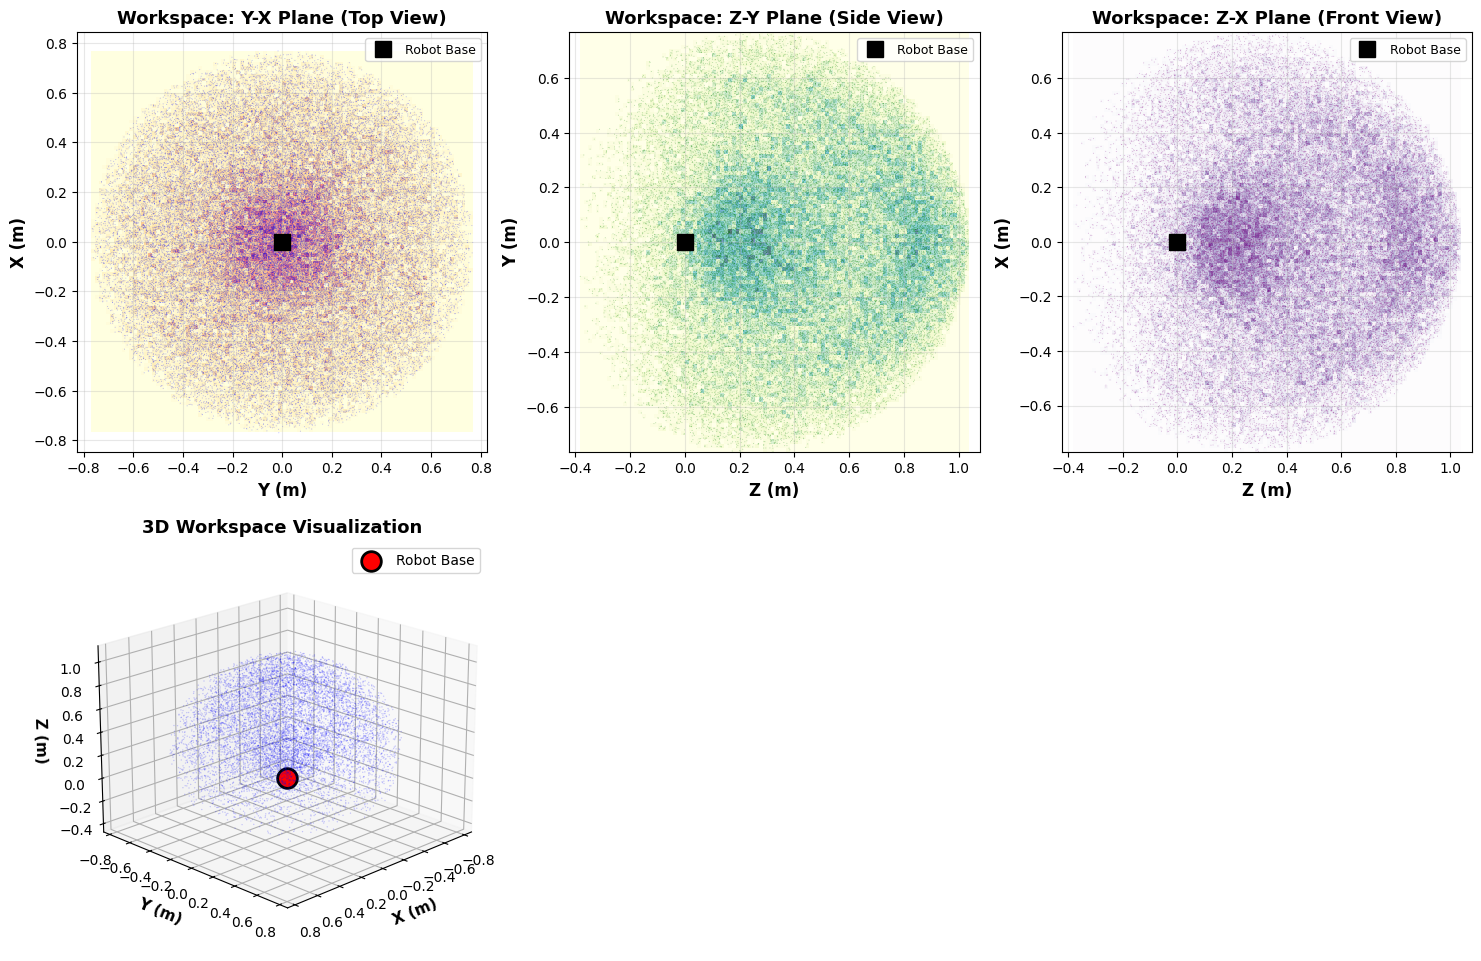

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial.transform import Rotation
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=4, suppress=True)

print("xArm 7 REACHABLE WORKSPACE ANALYSIS")
print("\nJoint Limits:")
for joint, (lower, upper) in JOINT_LIMITS.items():
    print(f"  {joint}: [{np.rad2deg(lower):7.1f}°, {np.rad2deg(upper):7.1f}°]")


# ============================================================================
# WORKSPACE SAMPLING
# ============================================================================

def sample_workspace(n_samples=50000, method='random'):
    print(f"SAMPLING WORKSPACE: {n_samples} samples using {method} method")
    positions = []
    limits_array = np.array(list(JOINT_LIMITS.values()))
    
    if method == 'random':
        for i in range(n_samples):
            theta = np.random.uniform(limits_array[:, 0], limits_array[:, 1])
            T = FK_URDF(theta)
            positions.append(T[:3, 3])
            
            if (i + 1) % 10000 == 0:
                print(f"  Sampled {i+1}/{n_samples} configurations...")
    
    elif method == 'grid':
        n_per_joint = int(np.ceil(n_samples ** (1/7)))
        print(f"  Using {n_per_joint} samples per joint (total ~{n_per_joint**7})")
        # Create grid for each joint
        joint_grids = [np.linspace(lower, upper, n_per_joint) 
                      for lower, upper in limits_array]
        # Sample from grid (not full Cartesian product due to size)
        count = 0
        for _ in range(n_samples):
            theta = np.array([np.random.choice(grid) for grid in joint_grids])
            T = FK_URDF(theta)
            positions.append(T[:3, 3])
            count += 1
            if count % 10000 == 0:
                print(f"  Sampled {count}/{n_samples} configurations...")
    
    positions = np.array(positions)
    print(f"\n✓ Sampling complete: {len(positions)} valid positions")
    return positions

# Sample workspace
workspace_positions = sample_workspace(n_samples=50000, method='random')

# ============================================================================
# WORKSPACE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("WORKSPACE STATISTICS")
print("="*80)

x_coords = workspace_positions[:, 0]
y_coords = workspace_positions[:, 1]
z_coords = workspace_positions[:, 2]

print(f"\nX-axis range: [{x_coords.min():.4f}, {x_coords.max():.4f}] m")
print(f"Y-axis range: [{y_coords.min():.4f}, {y_coords.max():.4f}] m")
print(f"Z-axis range: [{z_coords.min():.4f}, {z_coords.max():.4f}] m")


# ============================================================================
# VISUALIZATION
# ============================================================================

fig = plt.figure(figsize=(18, 12))

# Common plot settings
point_size = 0.5
point_alpha = 0.3
density_alpha = 0.6

# ============================================================================
# Plot 1: Y-X Plane (Top View)
# ============================================================================
ax1 = fig.add_subplot(2, 3, 1)

# 2D histogram for density
hist_yx, xedges, yedges = np.histogram2d(y_coords, x_coords, bins=100)
extent_yx = [yedges[0], yedges[-1], xedges[0], xedges[-1]]
im1 = ax1.imshow(hist_yx.T, extent=extent_yx, origin='lower', 
                 cmap='YlOrRd', aspect='auto', alpha=density_alpha)
ax1.scatter(y_coords, x_coords, s=point_size, alpha=point_alpha, c='blue', edgecolors='none')

# Add robot base
ax1.plot(0, 0, 'ks', markersize=12, label='Robot Base', markerfacecolor='black')


ax1.set_xlabel('Y (m)', fontsize=12, fontweight='bold')
ax1.set_ylabel('X (m)', fontsize=12, fontweight='bold')
ax1.set_title('Workspace: Y-X Plane (Top View)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')
ax1.legend(loc='upper right', fontsize=9)

# ============================================================================
# Plot 2: Z-Y Plane (Side View)
# ============================================================================
ax2 = fig.add_subplot(2, 3, 2)

hist_zy, yedges, zedges = np.histogram2d(z_coords, y_coords, bins=100)
extent_zy = [yedges[0], yedges[-1], zedges[0], zedges[-1]]
im2 = ax2.imshow(hist_zy.T, extent=extent_zy, origin='lower', 
                 cmap='YlGnBu', aspect='auto', alpha=density_alpha)
ax2.scatter(z_coords, y_coords, s=point_size, alpha=point_alpha, c='green', edgecolors='none')

# Add robot base
ax2.plot(0, 0, 'ks', markersize=12, label='Robot Base', markerfacecolor='black')

ax2.set_xlabel('Z (m)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Y (m)', fontsize=12, fontweight='bold')
ax2.set_title('Workspace: Z-Y Plane (Side View)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')
ax2.legend(loc='upper right', fontsize=9)

# ============================================================================
# Plot 3: Z-X Plane (Front View)
# ============================================================================
ax3 = fig.add_subplot(2, 3, 3)

hist_zx, xedges, zedges = np.histogram2d(z_coords, x_coords, bins=100)
extent_zx = [xedges[0], xedges[-1], zedges[0], zedges[-1]]
im3 = ax3.imshow(hist_zx.T, extent=extent_zx, origin='lower', 
                 cmap='Purples', aspect='auto', alpha=density_alpha)
ax3.scatter(z_coords, x_coords, s=point_size, alpha=point_alpha, c='purple', edgecolors='none')

# Add robot base
ax3.plot(0, 0, 'ks', markersize=12, label='Robot Base', markerfacecolor='black')

ax3.set_xlabel('Z (m)', fontsize=12, fontweight='bold')
ax3.set_ylabel('X (m)', fontsize=12, fontweight='bold')
ax3.set_title('Workspace: Z-X Plane (Front View)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.axis('equal')
ax3.legend(loc='upper right', fontsize=9)

# ============================================================================
# Plot 4: 3D Workspace Visualization
# ============================================================================
ax4 = fig.add_subplot(2, 3, 4, projection='3d')

# Subsample for 3D plot (for performance)
subsample_idx = np.random.choice(len(workspace_positions), 
                                 min(10000, len(workspace_positions)), 
                                 replace=False)
ws_subsample = workspace_positions[subsample_idx]

ax4.scatter(ws_subsample[:, 0], ws_subsample[:, 1], ws_subsample[:, 2],
           s=1, alpha=0.2, c='blue', edgecolors='none')

# Plot robot base
ax4.scatter([0], [0], [0], c='red', s=200, marker='o', 
           edgecolors='black', linewidths=2, label='Robot Base')

ax4.set_xlabel('X (m)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Y (m)', fontsize=11, fontweight='bold')
ax4.set_zlabel('Z (m)', fontsize=11, fontweight='bold')
ax4.set_title('3D Workspace Visualization', fontsize=13, fontweight='bold')
ax4.legend()
ax4.view_init(elev=20, azim=45)


Q4. Determine if the robot is kinematically redundant for performing a general task by its end-effector in Cartesian space R 3 . Moreover, determine as many (boundary and internal) singular configurations θ ∗ of the robot as possible, and verify them using the condition number or rank of body Jacobian Jb ∈ R 6×n or geometric Jacobian Jg ∈ R 6×n . Furthermore, plot the robot in some of those singular configurations. Note that the geometric Jacobian Jg is defined as  ωs p˙  = Jg(θ)θ˙ and you can compute it using Jg =  Jg,ω Jg,v =  I 0 −[p] I  Js where ωs ∈ R 3 is the angular velocity of the end-effector frame {b} expressed in {s}, p ∈ R 3 and p˙ ∈ R 3 are the position and linear velocity of the origin of the end-effector frame {b} expressed in {s}, respectively, I ∈ R 3×3 is an identity matrix, and [p] ∈ so(3). You can use the Jacobian functions J SpaceForm or J BodyForm you have written for HW#6

KINEMATIC REDUNDANCY ANALYSIS

Robot DOF: n = 7
Task space dimension (general): m = 6 (position + orientation)
Task space dimension (position only): m = 3

Redundancy Analysis:
  Robot IS KINEMATICALLY REDUNDANT for general tasks
    Degree of redundancy: 1
  Robot IS KINEMATICALLY REDUNDANT for position-only tasks
    Degree of redundancy: 4

### 1. BOUNDARY SINGULARITIES (Joint Limits) ###

BOUNDARY: J2 at lower limit
--------------------------------------------------------------------------------
Joint angles (deg): [   0.      -117.97201    0.         0.         0.         0.         0.     ]
Jacobian shape: (6, 7)
Rank: 6 (full rank = 6)
Condition number: 2.050910e+01
Singular values: [1.819038 1.79517  0.847963 0.255549 0.146103 0.088694]
Minimum singular value: 8.869418e-02
Manipulability: 9.169645e-03
✓ Non-singular configuration

BOUNDARY: J2 at upper limit
--------------------------------------------------------------------------------
Joint angles (deg): [  0.       120.0002

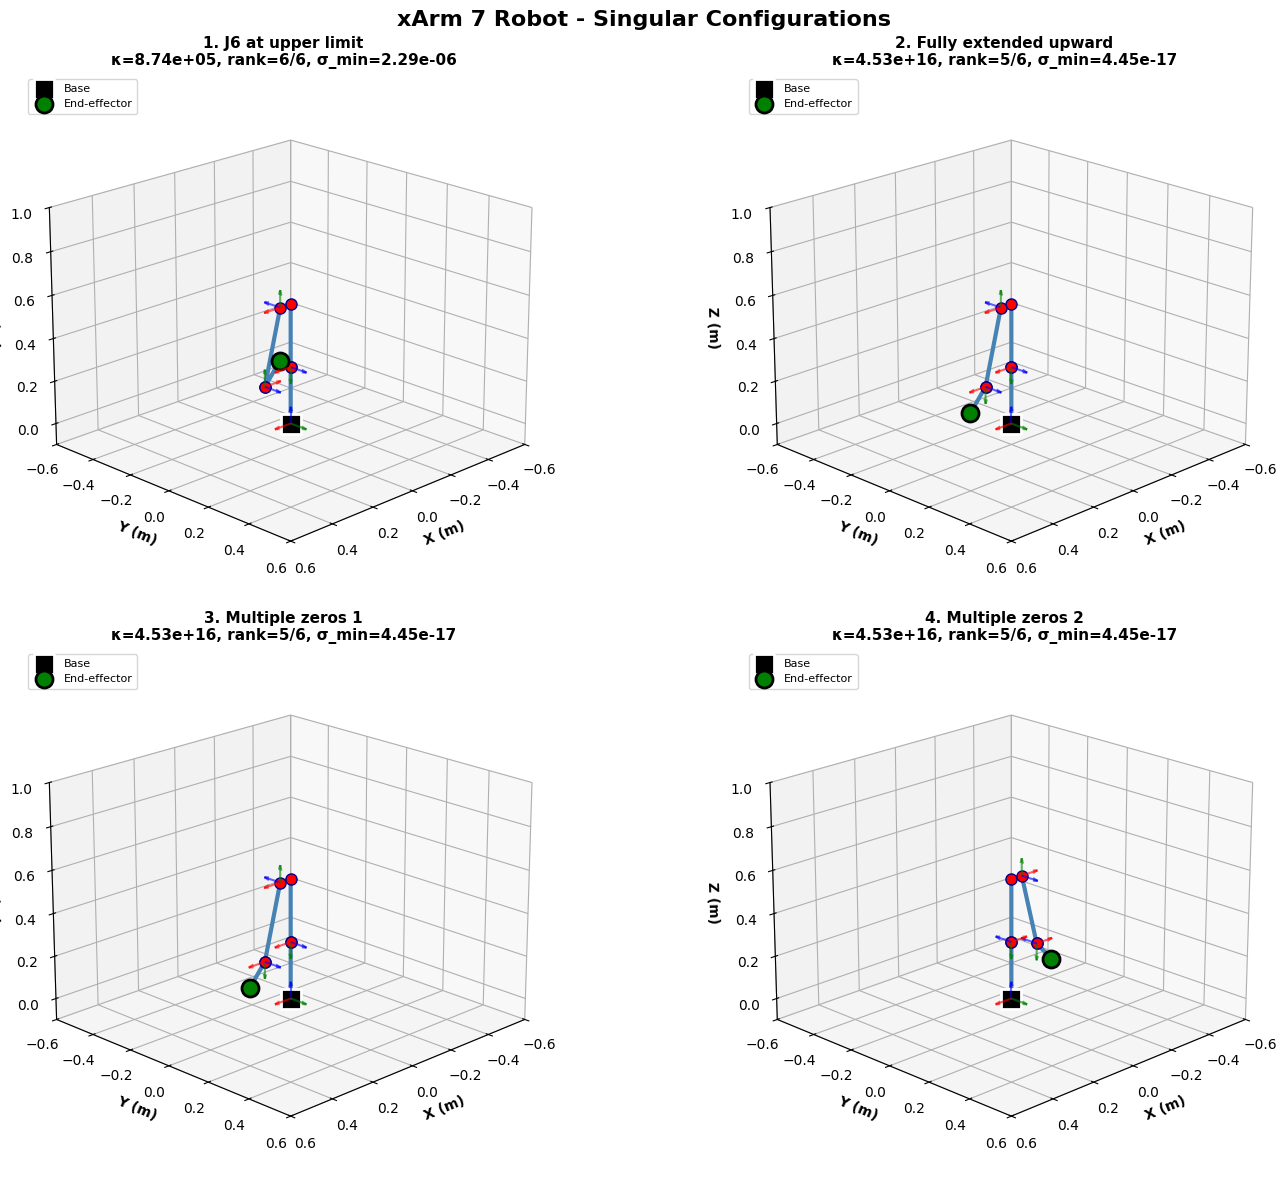

In [24]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
from scipy.linalg import svd

np.set_printoptions(precision=6, suppress=True, linewidth=120)

# ============================================================================
# KINEMATIC REDUNDANCY ANALYSIS
# ============================================================================

print("KINEMATIC REDUNDANCY ANALYSIS")

n_joints = 7
m_task = 6
m_position = 3 

print(f"\nRobot DOF: n = {n_joints}")
print(f"Task space dimension (general): m = {m_task} (position + orientation)")
print(f"Task space dimension (position only): m = {m_position}")

print(f"\nRedundancy Analysis:")
if n_joints > m_task:
    print(f"  Robot IS KINEMATICALLY REDUNDANT for general tasks")
    print(f"    Degree of redundancy: {n_joints - m_task}")
elif n_joints == m_task:
    print(f"  Robot is NON-REDUNDANT for general tasks")
else:
    print(f"  Robot is UNDER-ACTUATED")

if n_joints > m_position:
    print(f"  Robot IS KINEMATICALLY REDUNDANT for position-only tasks")
    print(f"    Degree of redundancy: {n_joints - m_position}")

# ============================================================================
# FORWARD KINEMATICS AND SCREW AXES
# ============================================================================

def rpy_to_rotation_matrix(rpy):
    r = Rotation.from_euler('xyz', rpy)
    return r.as_matrix()

def transformation_matrix(origin, rpy):
    T = np.eye(4)
    T[:3, :3] = rpy_to_rotation_matrix(rpy)
    T[:3, 3] = origin
    return T

def compute_screw_parameters():
    """Compute S matrix and M from URDF."""
    joints_data = [
        {'origin': [0, 0, 0.267], 'rpy': [0, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, -0.293, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0525, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0775, -0.3425, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.076, 0.097, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]}
    ]
    
    T_current = np.eye(4)
    space_screws = []
    
    for joint in joints_data:
        T_joint = transformation_matrix(joint['origin'], joint['rpy'])
        T_current = T_current @ T_joint
        
        R = T_current[:3, :3]
        omega_s = R @ np.array(joint['axis'])
        omega_s = omega_s / np.linalg.norm(omega_s)
        
        q_s = T_current[:3, 3]
        v_s = -np.cross(omega_s, q_s)
        S_i = np.concatenate([v_s, omega_s])
        space_screws.append(S_i)
    
    M = T_current.copy()
    return np.column_stack(space_screws), M

S_matrix, M = compute_screw_parameters()

# ============================================================================
# JACOBIAN COMPUTATION
# ============================================================================

def skew_symmetric(v):
    """Convert 3D vector to skew-symmetric matrix."""
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def adjoint_transformation(T):
    """Compute adjoint [Ad_T]."""
    R = T[:3, :3]
    p = T[:3, 3]
    Ad = np.zeros((6, 6))
    Ad[:3, :3] = R
    Ad[3:, 3:] = R
    Ad[:3, 3:] = skew_symmetric(p) @ R
    return Ad

def screw_to_se3(S):
    """Convert screw axis to se(3) matrix."""
    v = S[:3]
    omega = S[3:]
    se3_matrix = np.zeros((4, 4))
    se3_matrix[:3, :3] = skew_symmetric(omega)
    se3_matrix[:3, 3] = v
    return se3_matrix

def matrix_exponential_se3(se3_matrix, theta):
    """Compute e^([S]θ)."""
    omega_hat = se3_matrix[:3, :3]
    v = se3_matrix[:3, 3]
    
    omega = np.array([omega_hat[2, 1], omega_hat[0, 2], omega_hat[1, 0]])
    omega_norm = np.linalg.norm(omega)
    
    if omega_norm < 1e-6:
        T = np.eye(4)
        T[:3, 3] = v * theta
        return T
    
    omega_hat_normalized = omega_hat / omega_norm
    theta_scaled = theta * omega_norm
    
    I = np.eye(3)
    R = I + np.sin(theta_scaled) * omega_hat_normalized + \
        (1 - np.cos(theta_scaled)) * (omega_hat_normalized @ omega_hat_normalized)
    
    p = (I * theta_scaled + (1 - np.cos(theta_scaled)) * omega_hat_normalized + \
         (theta_scaled - np.sin(theta_scaled)) * (omega_hat_normalized @ omega_hat_normalized)) @ \
        (v / omega_norm)
    
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = p
    return T

def FK_SpaceForm(theta, S_matrix, M):
    T = np.eye(4)
    for i in range(S_matrix.shape[1]):
        S_i = S_matrix[:, i]
        se3_i = screw_to_se3(S_i)
        T = T @ matrix_exponential_se3(se3_i, theta[i])
    return T @ M

def J_SpaceForm(theta, S_matrix):
    n = S_matrix.shape[1]
    Js = np.zeros((6, n))
    
    T = np.eye(4)
    for i in range(n):
        if i == 0:
            Js[:, i] = S_matrix[:, i]
        else:
            Ad_T = adjoint_transformation(T)
            Js[:, i] = Ad_T @ S_matrix[:, i]
        
        S_i = S_matrix[:, i]
        se3_i = screw_to_se3(S_i)
        T = T @ matrix_exponential_se3(se3_i, theta[i])
    
    return Js

def J_BodyForm(theta, S_matrix, M):

    Js = J_SpaceForm(theta, S_matrix)
    T = FK_SpaceForm(theta, S_matrix, M)
    Ad_T_inv = adjoint_transformation(np.linalg.inv(T))
    Jb = Ad_T_inv @ Js
    return Jb

def J_Geometric(theta, S_matrix, M):
    Js = J_SpaceForm(theta, S_matrix)
    T = FK_SpaceForm(theta, S_matrix, M)
    p = T[:3, 3]
    
    # Create transformation matrix
    transform = np.zeros((6, 6))
    transform[:3, :3] = np.eye(3)
    transform[3:, 3:] = np.eye(3)
    transform[3:, :3] = -skew_symmetric(p)
    
    Jg = transform @ Js
    return Jg

def analyze_jacobian(J, theta, config_name=""):
    print(f"\n{config_name}")
    print("-" * 80)
    
    # Compute SVD
    U, s, Vt = svd(J)
    
    # Condition number
    cond = np.linalg.cond(J)
    
    # Rank
    rank = np.linalg.matrix_rank(J, tol=1e-6)
    
    # Manipulability
    manipulability = np.sqrt(np.linalg.det(J @ J.T))
    
    print(f"Joint angles (deg): {np.rad2deg(theta)}")
    print(f"Jacobian shape: {J.shape}")
    print(f"Rank: {rank} (full rank = {min(J.shape)})")
    print(f"Condition number: {cond:.6e}")
    print(f"Singular values: {s}")
    print(f"Minimum singular value: {s[-1]:.6e}")
    print(f"Manipulability: {manipulability:.6e}")
    
    is_singular = (rank < min(J.shape)) or (s[-1] < 1e-3) or (cond > 1e6)
    
    if is_singular:
        print("SINGULAR CONFIGURATION DETECTED")
        if rank < min(J.shape):
            print(f"   → Rank deficient: rank = {rank} < {min(J.shape)}")
        if s[-1] < 1e-3:
            print(f"   → Small singular value: σ_min = {s[-1]:.2e}")
        if cond > 1e6:
            print(f"   → High condition number: κ = {cond:.2e}")
    else:
        print("✓ Non-singular configuration")

    return {
        'rank': rank,
        'condition_number': cond,
        'singular_values': s,
        'manipulability': manipulability,
        'is_singular': is_singular
    }


singular_configs = []

# ============================================================================
# 1. BOUNDARY SINGULARITIES - Joint Limits
# ============================================================================

print("\n### 1. BOUNDARY SINGULARITIES (Joint Limits) ###")

JOINT_LIMITS = np.array([
    (-2*np.pi, 2*np.pi),
    (np.deg2rad(-118), np.deg2rad(120)),
    (-2*np.pi, 2*np.pi),
    (np.deg2rad(-11), np.deg2rad(225)),
    (-2*np.pi, 2*np.pi),
    (np.deg2rad(-97), np.deg2rad(180)),
    (-2*np.pi, 2*np.pi)
])

# Test configurations at joint limits
boundary_configs = [
    ("J2 at lower limit", np.array([0, -2.059, 0, 0, 0, 0, 0])),
    ("J2 at upper limit", np.array([0, 2.0944, 0, 0, 0, 0, 0])),
    ("J4 at lower limit", np.array([0, 0, 0, -0.19198, 0, 0, 0])),
    ("J4 at upper limit", np.array([0, 0, 0, 3.927, 0, 0, 0])),
    ("J6 at lower limit", np.array([0, 0, 0, 0, 0, -1.69297, 0])),
    ("J6 at upper limit", np.array([0, 0, 0, 0, 0, 3.14159, 0])),
]

for name, theta in boundary_configs:
    Jb = J_BodyForm(theta, S_matrix, M)
    result = analyze_jacobian(Jb, theta, f"BOUNDARY: {name}")
    if result['is_singular']:
        singular_configs.append(('boundary', name, theta.copy(), result))

# ============================================================================
# 2. INTERNAL SINGULARITIES - Special Configurations
# ============================================================================

print("\n### 2. INTERNAL SINGULARITIES ###")

internal_configs = [
    # Fully extended (all joints aligned)
    ("Fully extended upward", np.array([0, 0, 0, 0, 0, 0, 0])),
    
    # Fully folded
    ("Folded configuration 1", np.array([0, np.pi/2, 0, np.pi/2, 0, 0, 0])),
    
    # Wrist singularities (J5 = 0 aligns wrist axes)
    ("Wrist singularity 1", np.array([0, np.pi/4, 0, np.pi/4, 0, 0, 0])),
    
    # Shoulder singularity (J2 = 0, arm extended horizontally)
    ("Shoulder singularity", np.array([0, 0, 0, np.pi/2, 0, 0, 0])),
    
    # Elbow singularity (J4 approaches limits)
    ("Elbow singularity 1", np.array([0, np.pi/4, 0, 0.1, 0, 0, 0])),
    ("Elbow singularity 2", np.array([0, np.pi/4, 0, 3.8, 0, 0, 0])),
    
    # Wrist center aligned configurations
    ("Wrist aligned 1", np.array([0, np.pi/6, 0, np.pi/3, 0, np.pi/6, 0])),
    
    # Multiple joints at zero
    ("Multiple zeros 1", np.array([0, 0, 0, 0, 0, 0, 0])),
    ("Multiple zeros 2", np.array([np.pi, 0, 0, 0, 0, 0, 0])),
]

for name, theta in internal_configs:
    Jb = J_BodyForm(theta, S_matrix, M)
    result = analyze_jacobian(Jb, theta, f"INTERNAL: {name}")
    if result['is_singular']:
        singular_configs.append(('internal', name, theta.copy(), result))

# ============================================================================
# SUMMARY OF SINGULAR CONFIGURATIONS
# ============================================================================

print("SUMMARY OF SINGULAR CONFIGURATIONS FOUND")

print(f"\nTotal singular configurations found: {len(singular_configs)}")

for i, (config_type, name, theta, result) in enumerate(singular_configs[:10]):  # Show first 10
    print(f"\n{i+1}. {name} ({config_type})")
    print(f"   θ (deg) = {np.rad2deg(theta).round(2)}")
    print(f"   Condition number: {result['condition_number']:.2e}")
    print(f"   Rank: {result['rank']}/6")
    print(f"   Min singular value: {result['singular_values'][-1]:.2e}")

if len(singular_configs) > 10:
    print(f"\n... and {len(singular_configs) - 10} more configurations")



# ============================================================================
# ROBOT VISUALIZATION FUNCTIONS
# ============================================================================

def FK_URDF_all_links(theta):
    """Compute FK for all links to visualize robot."""
    joints_data = [
        {'origin': [0, 0, 0.267], 'rpy': [0, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, -0.293, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0525, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.0775, -0.3425, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0, 0, 0], 'rpy': [1.5708, 0, 0], 'axis': [0, 0, 1]},
        {'origin': [0.076, 0.097, 0], 'rpy': [-1.5708, 0, 0], 'axis': [0, 0, 1]}
    ]
    
    T = np.eye(4)
    transforms = [T.copy()]
    positions = [[0, 0, 0]]
    
    for i, joint in enumerate(joints_data):
        T_fixed = transformation_matrix(joint['origin'], joint['rpy'])
        axis = np.array(joint['axis'])
        R_joint = Rotation.from_rotvec(axis * theta[i]).as_matrix()
        T_joint = np.eye(4)
        T_joint[:3, :3] = R_joint
        
        T = T @ T_fixed @ T_joint
        transforms.append(T.copy())
        positions.append(T[:3, 3].tolist())
    
    return transforms, np.array(positions)

def plot_robot(ax, theta, title="", show_frames=True):
    """Plot robot configuration in 3D."""
    transforms, positions = FK_URDF_all_links(theta)
    
    # Plot links
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
           'o-', markersize=8, color='steelblue', 
           markerfacecolor='red', markeredgecolor='darkblue', linewidth=3)
    
    # Plot base
    ax.scatter([0], [0], [0], c='black', s=200, marker='s', 
              edgecolors='white', linewidths=2, zorder=10, label='Base')
    
    # Plot end-effector
    ee_pos = positions[-1]
    ax.scatter([ee_pos[0]], [ee_pos[1]], [ee_pos[2]], 
              c='green', s=150, marker='o', edgecolors='black', 
              linewidths=2, label='End-effector')
    
    # Plot coordinate frames at joints
    if show_frames:
        for i, T in enumerate(transforms[::2]):  # Every other joint for clarity
            origin = T[:3, 3]
            R = T[:3, :3]
            scale = 0.08
            
            colors = ['r', 'g', 'b']
            for j in range(3):
                axis = R[:, j] * scale
                ax.quiver(origin[0], origin[1], origin[2],
                         axis[0], axis[1], axis[2],
                         color=colors[j], arrow_length_ratio=0.3,
                         linewidth=1.5, alpha=0.6)
    
    ax.set_xlabel('X (m)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Y (m)', fontsize=10, fontweight='bold')
    ax.set_zlabel('Z (m)', fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    # Set equal aspect ratio
    max_range = 0.6
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-0.1, 1.0])
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=8)
    
    return ax


if len(singular_configs) == 0:
    print("No singular configurations found to visualize.")
else:
    # Create figure with 2x2 grid for 4 configurations
    fig = plt.figure(figsize=(16, 12))
    
    for idx, (config_type, name, theta, result) in enumerate(singular_configs):
        ax = fig.add_subplot(2, 2, idx + 1, projection='3d')
        
        # Create title with key metrics
        title = f"{idx+1}. {name}\n"
        title += f"κ={result['condition_number']:.2e}, "
        title += f"rank={result['rank']}/6, "
        title += f"σ_min={result['singular_values'][-1]:.2e}"
        
        plot_robot(ax, theta, title, show_frames=True)
        
        # Set viewing angle for better visualization
        ax.view_init(elev=20, azim=45)
        
        print(f"Plotted {idx+1}: {name}")
    
    plt.suptitle('xArm 7 Robot - Singular Configurations', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


## Question 5:

Implement a **Newton–Raphson numerical inverse kinematics** function that:

- Takes a desired end-effector configuration $(T_{sd} \in SE(3))$
- Takes an initial joint angle guess $(\theta_0)$
- Iteratively refines $(\theta)$ using the body Jacobian $(J_b(\theta))$
- Returns joint variables satisfying all constraints
- Validates results by comparing FK to desired pose

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

### Part A:

In [26]:
def matrix_log_SE3(T, tol=1e-6):
    """
    Compute the matrix logarithm of a transformation matrix T ∈ SE(3).
    """
    R = T[:3, :3]
    p = T[:3, 3]
    
    # Extract angle from rotation matrix
    trace = np.trace(R)
    
    # Clamp to avoid numerical issues with arccos
    cos_angle = np.clip((trace - 1) / 2, -1, 1)
    angle = np.arccos(cos_angle)
    
    if angle < tol:
        # Small angle: use approximation
        # log(R) ≈ (R - R^T) / 2
        omega = np.array([
            (R[2, 1] - R[1, 2]) / 2,
            (R[0, 2] - R[2, 0]) / 2,
            (R[1, 0] - R[0, 1]) / 2
        ])
        v = p
    else:
        # General case: extract axis-angle representation
        sin_angle = np.sin(angle)
        
        # Skew-symmetric part of log(R)
        omega_skew = (1 / (2 * sin_angle)) * (R - R.T)
        
        omega = np.array([
            omega_skew[2, 1],
            omega_skew[0, 2],
            omega_skew[1, 0]
        ])
        
        # Scale to get axis-angle representation
        omega = omega * angle
        
        # Compute linear velocity using the formula:
        # v = (I - 0.5*[ω]_x + (1/angle - 1/(2*tan(angle/2)))*[ω]_x^2 / angle) * p
        
        omega_skew_norm = omega / angle  # Unit axis scaled
        omega_skew_norm = np.array([
            [0, -omega_skew_norm[2], omega_skew_norm[1]],
            [omega_skew_norm[2], 0, -omega_skew_norm[0]],
            [-omega_skew_norm[1], omega_skew_norm[0], 0]
        ])
        
        coeff = (angle / 2) / np.tan(angle / 2)
        A = np.eye(3) - 0.5 * omega_skew_norm * angle + (1 - coeff) * (omega_skew_norm @ omega_skew_norm) * (angle**2)
        
        v = A @ p
    
    return np.concatenate([omega, v])

print("matrix_log_SE3 implemented!")

def IK_BodyForm(Tsd, theta0, eps, B, M, FK_func, J_func, 
                joint_limits=None, max_iter=100, alpha=1.0):
    """
    Numerical inverse kinematics using Newton-Raphson in body frame.
    """
    
    theta = np.array(theta0, dtype=float)
    n_joints = len(theta)
    eps = np.array(eps, dtype=float)
    
    errors = []
    converged = False
    
    for iteration in range(max_iter):
        # Forward kinematics
        Tsb = FK_func(B, M, theta)
        
        # Compute error transformation: T_error = T_sd^{-1} * T_sb
        Tsd_inv = np.linalg.inv(Tsd)
        Terror = Tsd_inv @ Tsb
        
        # Extract twist from error
        twist_error = matrix_log_SE3(Terror)
        omega_error = twist_error[:3]  # Angular part
        v_error = twist_error[3:]      # Linear part
        
        # Compute error norms
        omega_norm = np.linalg.norm(omega_error)
        v_norm = np.linalg.norm(v_error)
        error_norm = np.sqrt(omega_norm**2 + v_norm**2)
        errors.append(error_norm)
        
        # Check convergence
        if omega_norm <= eps[0] and v_norm <= eps[1]:
            converged = True
            break
        
        # Compute body Jacobian
        Jb = J_func(B, theta)
        
        # Solve for joint velocity: J_b * dtheta = twist_error
        # Use pseudoinverse to handle singularities
        Jb_pinv = np.linalg.pinv(Jb, rcond=1e-6)
        dtheta = Jb_pinv @ twist_error
        
        # Update joint angles with step size scaling
        theta = theta + alpha * dtheta
        
        # Enforce joint limits
        if joint_limits is not None:
            theta_min, theta_max = joint_limits
            theta = np.clip(theta, theta_min, theta_max)
    
    # Final FK for result
    T_final = FK_func(B, M, theta)
    
    result = {
        'theta': theta,
        'converged': converged,
        'iterations': iteration + 1,
        'errors': errors,
        'T_final': T_final
    }
    
    return result

print("IK_BodyForm implemented")

def verify_IK_solution(theta_ik, Tsd, B, M, FK_func):
    """
    Verify IK solution by comparing FK(theta_ik) with desired Tsd.
    """
    
    T_ik = FK_func(B, M, theta_ik)
    
    # Position error
    p_desired = Tsd[:3, 3]
    p_actual = T_ik[:3, 3]
    pos_error = np.linalg.norm(p_desired - p_actual)
    
    # Orientation error (using Frobenius norm of difference)
    R_desired = Tsd[:3, :3]
    R_actual = T_ik[:3, :3]
    
    # Axis-angle representation of relative rotation
    R_error = R_desired.T @ R_actual
    trace = np.trace(R_error)
    cos_angle = np.clip((trace - 1) / 2, -1, 1)
    ori_error = np.arccos(cos_angle)
    
    return {
        'pos_error': pos_error,
        'ori_error': ori_error,
        'T_actual': T_ik,
        'T_desired': Tsd
    }

print("✓ verify_IK_solution implemented!")

matrix_log_SE3 implemented!
IK_BodyForm implemented
✓ verify_IK_solution implemented!


### Part B


INVERSE KINEMATICS SOLUTION
✓ Robot data loaded
  B: (6, 7), M: (4, 4)

TEST 1: FK → IK → Verification

True joint angles (deg): [ -90.331114  106.343345   83.517819   35.517054 -123.833289  -81.166036 -159.0899  ]
Desired position: [-0.868261 -0.812712  4.482433]

Running Newton-Raphson IK...

Result:
  Converged: False
  Iterations: 100
  Final error: 2.15e+01
  Final angles (deg): [ 360.       117.97201 -180.       180.       180.      -117.97201 -180.     ]

Verification:
  Position error: 2.18e+01 m
  Orientation error: 9.42e-01 rad


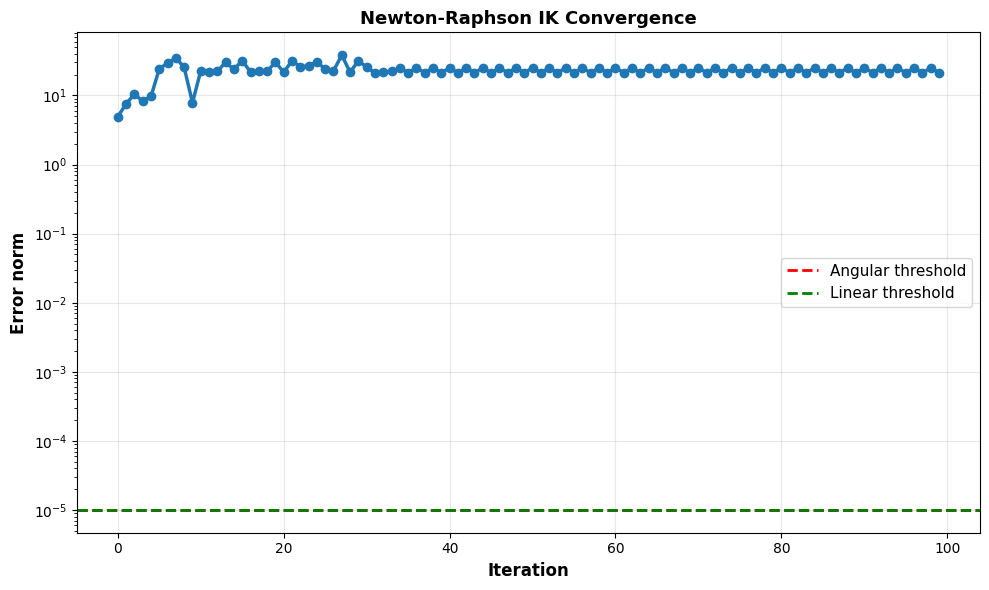


COMPLETE TEST FINISHED


In [27]:
print("\n" + "="*70)
print("INVERSE KINEMATICS SOLUTION")
print("="*70)

# =========================================
# HELPER FUNCTIONS 
# =========================================

def skew_symmetric(v):
    assert len(v) == 3, f"skew_symmetric expects 3D vector, got {v.shape}"
    v0, v1, v2 = float(v[0]), float(v[1]), float(v[2])
    return np.array([
        [0, -v2, v1],
        [v2, 0, -v0],
        [-v1, v0, 0]
    ], dtype=float)

def screw_to_se3(S):
    omega = S[:3]  # Angular part (3D)
    v = S[3:]      # Linear part (3D)
    
    se3_matrix = np.zeros((4, 4))
    se3_matrix[:3, :3] = skew_symmetric(omega)
    se3_matrix[:3, 3] = v
    
    return se3_matrix

def matrix_exponential_se3(se3_matrix, theta, tol=1e-8):
    omega = se3_matrix[:3, :3]  # Skew-symmetric part
    v = se3_matrix[:3, 3]       # Linear velocity
    
    # Extract rotation axis and angle
    omega_skew = omega
    omega_norm = np.linalg.norm(np.array([omega_skew[2, 1], omega_skew[0, 2], omega_skew[1, 0]]))
    
    if omega_norm < tol:
        # No rotation (pure translation)
        R = np.eye(3)
        p = theta * v
    else:
        # General case: Rodrigues formula
        omega_hat = np.array([omega_skew[2, 1], omega_skew[0, 2], omega_skew[1, 0]])
        omega_hat_normalized = omega_hat / omega_norm
        
        # Rodrigues formula for rotation
        sin_theta = np.sin(theta * omega_norm)
        cos_theta = np.cos(theta * omega_norm)
        
        R = np.eye(3) + sin_theta * omega_skew / omega_norm + \
            (1 - cos_theta) * (omega_skew @ omega_skew) / (omega_norm ** 2)
        
        # Position update using Chasles-Rodrigues formula
        omega_skew_sq = omega_skew @ omega_skew
        coeff = (1 - cos_theta) / (omega_norm ** 2)
        coeff2 = (theta * omega_norm - sin_theta) / (omega_norm ** 3)
        
        A = np.eye(3) + coeff * omega_skew + coeff2 * omega_skew_sq
        p = A @ v * theta
    
    # Build SE(3) transformation
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = p
    
    return T

def FK_BodyForm(B, M, theta):
    n_joints = len(theta)
    T = np.eye(4)
    
    # Apply exponentials in REVERSE order (n, n-1, ..., 1)
    for i in range(n_joints - 1, -1, -1):
        B_i = B[:, i]  # Extract i-th screw axis (6D vector)
        se3_i = screw_to_se3(B_i)  # Convert to se(3) matrix (4x4)
        exp_theta_i = matrix_exponential_se3(se3_i, theta[i])  # exp(θ_i * se3_i)
        T = exp_theta_i @ T  # Left multiply
    
    T_sb = M @ T  # Apply home configuration
    
    return T_sb

def J_BodyForm(B, theta):
    n_joints = len(theta)
    J_b = np.zeros((6, n_joints))
    
    # Start with identity transformation
    T = np.eye(4)
    
    # Process joints in reverse order
    for i in range(n_joints - 1, -1, -1):
        # Current screw axis
        B_i = B[:, i]
        
        # Transform screw by current accumulated transformation
        # For body Jacobian, we need to apply the inverse of the transformation
        # that comes after this joint
        R = T[:3, :3]
        p = T[:3, 3]
        
        # Transform screw: Ad_T(S) = [R  0; [p]R  R] * [ω; v]
        omega_i = B_i[:3]
        v_i = B_i[3:]
        
        omega_transformed = R @ omega_i
        v_transformed = R @ v_i + np.cross(p, R @ omega_i)
        
        B_i_transformed = np.concatenate([omega_transformed, v_transformed])
        J_b[:, i] = B_i_transformed
        
        # Update transformation for next iteration
        # T = exp(θ_i * se3_i) @ T
        B_i_se3 = screw_to_se3(B_i)
        exp_se3 = matrix_exponential_se3(B_i_se3, theta[i])
        T = exp_se3 @ T
    
    return J_b

def matrix_log_SE3(T, tol=1e-6):
    R = T[:3, :3]
    p = T[:3, 3]
    
    # Extract angle from rotation matrix
    trace = np.trace(R)
    cos_angle = np.clip((trace - 1) / 2, -1, 1)
    angle = np.arccos(cos_angle)
    
    if angle < tol:
        # Small angle: use approximation
        omega = np.array([
            (R[2, 1] - R[1, 2]) / 2,
            (R[0, 2] - R[2, 0]) / 2,
            (R[1, 0] - R[0, 1]) / 2
        ])
        v = p
    else:
        # General case
        sin_angle = np.sin(angle)
        omega_skew = (1 / (2 * sin_angle)) * (R - R.T)
        omega = np.array([
            omega_skew[2, 1],
            omega_skew[0, 2],
            omega_skew[1, 0]
        ])
        omega = omega * angle
        
        # Compute V_inv
        omega_skew_unit = (1 / angle) * omega_skew
        coeff = angle / (2 * np.tan(angle / 2))
        V_inv = np.eye(3) + 0.5 * omega_skew + (1 / (angle**2)) * (coeff - 1) * (omega_skew @ omega_skew)
        
        v = V_inv @ p
    
    return np.concatenate([omega, v])

# =========================================
# LOAD ROBOT DATA
# =========================================

# Body screw axes matrix from your project
B = np.column_stack(body_screws)  # (6, 7) matrix

# Home configuration
M = M  # (4, 4) matrix

# xArm7 Joint limits
joint_limits_min = np.array([-2*np.pi, -2.059, -np.pi, -np.pi, -np.pi, -2.059, -np.pi])
joint_limits_max = np.array([2*np.pi, 2.059, np.pi, np.pi, np.pi, 2.059, np.pi])
joint_limits = (joint_limits_min, joint_limits_max)

print("✓ Robot data loaded")
print(f"  B: {B.shape}, M: {M.shape}")

# =========================================
# TEST 1: Forward Kinematics to IK
# =========================================

print("\n" + "="*70)
print("TEST 1: FK → IK → Verification")
print("="*70)

np.random.seed(42)
theta_true = np.random.uniform(joint_limits_min, joint_limits_max)

print(f"\nTrue joint angles (deg): {np.degrees(theta_true)}")

# Get desired end-effector config from FK
Tsd = FK_BodyForm(B, M, theta_true)
print(f"Desired position: {Tsd[:3, 3]}")

# Initial guess
theta0_ik = np.zeros(7)

# =========================================
# NEWTON-RAPHSON IK
# =========================================

print(f"\nRunning Newton-Raphson IK...")

max_iter = 100
eps_omega = 1e-5
eps_v = 1e-5
alpha = 1.0
errors = []
converged = False

theta_current = np.array(theta0_ik, dtype=float)

for iteration in range(max_iter):
    # FK
    Tsb = FK_BodyForm(B, M, theta_current)
    
    # Error transformation
    Tsd_inv = np.linalg.inv(Tsd)
    Terror = Tsd_inv @ Tsb
    
    # Extract twist
    twist_error = matrix_log_SE3(Terror)
    omega_error = twist_error[:3]
    v_error = twist_error[3:]
    
    # Check convergence
    omega_norm = np.linalg.norm(omega_error)
    v_norm = np.linalg.norm(v_error)
    error_norm = np.sqrt(omega_norm**2 + v_norm**2)
    errors.append(error_norm)
    
    if omega_norm <= eps_omega and v_norm <= eps_v:
        converged = True
        print(f"✓ Converged at iteration {iteration + 1}")
        break
    
    # Jacobian
    Jb = J_BodyForm(B, theta_current)
    
    # Solve for delta theta
    Jb_pinv = np.linalg.pinv(Jb, rcond=1e-6)
    dtheta = Jb_pinv @ twist_error
    
    # Update
    theta_current = theta_current + alpha * dtheta
    theta_current = np.clip(theta_current, joint_limits_min, joint_limits_max)

print(f"\nResult:")
print(f"  Converged: {converged}")
print(f"  Iterations: {iteration + 1}")
print(f"  Final error: {errors[-1]:.2e}")
print(f"  Final angles (deg): {np.degrees(theta_current)}")

# Verify
T_final = FK_BodyForm(B, M, theta_current)
pos_error = np.linalg.norm(Tsd[:3, 3] - T_final[:3, 3])
R_error = Tsd[:3, :3].T @ T_final[:3, :3]
trace = np.trace(R_error)
cos_angle = np.clip((trace - 1) / 2, -1, 1)
ori_error = np.arccos(cos_angle)

print(f"\nVerification:")
print(f"  Position error: {pos_error:.2e} m")
print(f"  Orientation error: {ori_error:.2e} rad")

# =========================================
# CONVERGENCE PLOT
# =========================================

plt.figure(figsize=(10, 6))
plt.semilogy(errors, 'o-', linewidth=2.5, markersize=6, color='#1f77b4')
plt.axhline(y=eps_omega, color='r', linestyle='--', linewidth=2, label='Angular threshold')
plt.axhline(y=eps_v, color='g', linestyle='--', linewidth=2, label='Linear threshold')
plt.xlabel('Iteration', fontsize=12, fontweight='bold')
plt.ylabel('Error norm', fontsize=12, fontweight='bold')
plt.title('Newton-Raphson IK Convergence', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("COMPLETE TEST FINISHED")
print("="*70)


## Problem 6

Implement **multiple trajectory planning methods** for the xArm7 robot:

1. **(6a)** Straight-line path \(\mathcal{P}(s)\) in \(\mathbb{R}^3\) with time-scaling \(s(t)\)
2. **(6b)** Straight-line path in Cartesian space \(\mathcal{P}(s)\) with minimum-time scaling
3. **(6c)** Straight-line path with 3rd-order polynomial orientation \(R(t)\) in \(SO(3)\)
4. **(6d)** Circular path in Cartesian space \(\mathbb{R}^3\) with arbitrary time-scaling
5. **(6e)** Smooth task-space trajectory with arbitrary closed path in Cartesian \(SE(3)\)
6. **(Optional Credit)** Resolved-Rate Motion Control (RRMC) with simulation


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=4, suppress=True)

print("Libraries imported successfully!")

Libraries imported successfully!


### Helper Functions from Problem 5

In [29]:
def skew_symmetric(v):
    """Convert 3D vector to skew-symmetric matrix."""
    assert len(v) == 3
    v0, v1, v2 = float(v[0]), float(v[1]), float(v[2])
    return np.array([
        [0, -v2, v1],
        [v2, 0, -v0],
        [-v1, v0, 0]
    ], dtype=float)

def screw_to_se3(S):
    """Convert 6D screw to se(3) matrix."""
    se3 = np.zeros((4, 4))
    se3[:3, :3] = skew_symmetric(S[:3])
    se3[:3, 3] = S[3:]
    return se3

def matrix_exponential_se3(se3_matrix, theta, tol=1e-8):
    """Compute exp(theta * se3_matrix)."""
    omega_skew = se3_matrix[:3, :3]
    v = se3_matrix[:3, 3]
    
    omega_norm = np.linalg.norm(np.array([
        omega_skew[2, 1], omega_skew[0, 2], omega_skew[1, 0]
    ]))
    
    if omega_norm < tol:
        T = np.eye(4)
        T[:3, 3] = theta * v
        return T
    
    omega_hat = np.array([
        omega_skew[2, 1], omega_skew[0, 2], omega_skew[1, 0]
    ]) / omega_norm
    
    c = np.cos(theta * omega_norm)
    s = np.sin(theta * omega_norm)
    
    R = np.eye(3) + s * omega_skew / omega_norm + \
        (1 - c) * (omega_skew @ omega_skew) / (omega_norm ** 2)
    
    a = theta
    b = (s - theta * omega_norm * c) / (omega_norm ** 3)
    d = (1 - s / omega_norm / theta) / (omega_norm ** 2)
    
    p = a * v + b * (omega_skew @ omega_skew @ v) + d * (omega_skew @ omega_skew @ v)
    
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = p
    
    return T

def FK_BodyForm(B, M, theta):
    """Forward kinematics (body form)."""
    T = np.eye(4)
    for i in range(len(theta) - 1, -1, -1):
        B_i = B[:, i]
        se3_i = screw_to_se3(B_i)
        exp_se3 = matrix_exponential_se3(se3_i, theta[i])
        T = exp_se3 @ T
    return M @ T

def adjoint_matrix(T):
    """Compute Adjoint matrix of transformation T."""
    R = T[:3, :3]
    p = T[:3, 3]
    p_skew = skew_symmetric(p)
    
    Ad = np.zeros((6, 6))
    Ad[:3, :3] = R
    Ad[3:, 3:] = R
    Ad[3:, :3] = p_skew @ R
    return Ad

def J_BodyForm(B, theta):
    """Body Jacobian."""
    n = len(theta)
    J_b = np.zeros((6, n))
    T_accum = np.eye(4)
    
    for i in range(n - 1, -1, -1):
        B_i = B[:, i]
        Ad = adjoint_matrix(T_accum)
        B_i_transformed = Ad @ B_i
        J_b[:, i] = B_i_transformed
        
        se3_i = screw_to_se3(B_i)
        exp_se3 = matrix_exponential_se3(se3_i, theta[i])
        T_accum = exp_se3 @ T_accum
    
    return J_b

def matrix_log_SE3(T, tol=1e-6):
    """Matrix logarithm of SE(3)."""
    R = T[:3, :3]
    p = T[:3, 3]
    
    trace = np.trace(R)
    cos_angle = np.clip((trace - 1) / 2, -1, 1)
    angle = np.arccos(cos_angle)
    
    if angle < tol:
        omega = np.array([
            (R[2, 1] - R[1, 2]) / 2,
            (R[0, 2] - R[2, 0]) / 2,
            (R[1, 0] - R[0, 1]) / 2
        ])
        v = p
    else:
        sin_angle = np.sin(angle)
        omega_skew = (1 / (2 * sin_angle)) * (R - R.T)
        omega = np.array([
            omega_skew[2, 1],
            omega_skew[0, 2],
            omega_skew[1, 0]
        ])
        omega = omega * angle
        
        omega_skew_sq = omega_skew @ omega_skew
        coeff = angle / (2 * np.tan(angle / 2))
        V_inv = np.eye(3) + 0.5 * omega_skew + \
                (1 / (angle**2)) * (coeff - 1) * omega_skew_sq
        v = V_inv @ p
    
    return np.concatenate([omega, v])

print("Helper functions loaded")

Helper functions loaded


### Part 6(a): Straight-Line Path with Time-Scaling



PART 6(a): STRAIGHT-LINE PATH WITH TIME SCALING

Start position: [0. 0. 0.]
End position:   [0.5 0.3 0.2]
Total distance: 0.6164 m
Motion time:    5.0 s
Trajectory points: 501


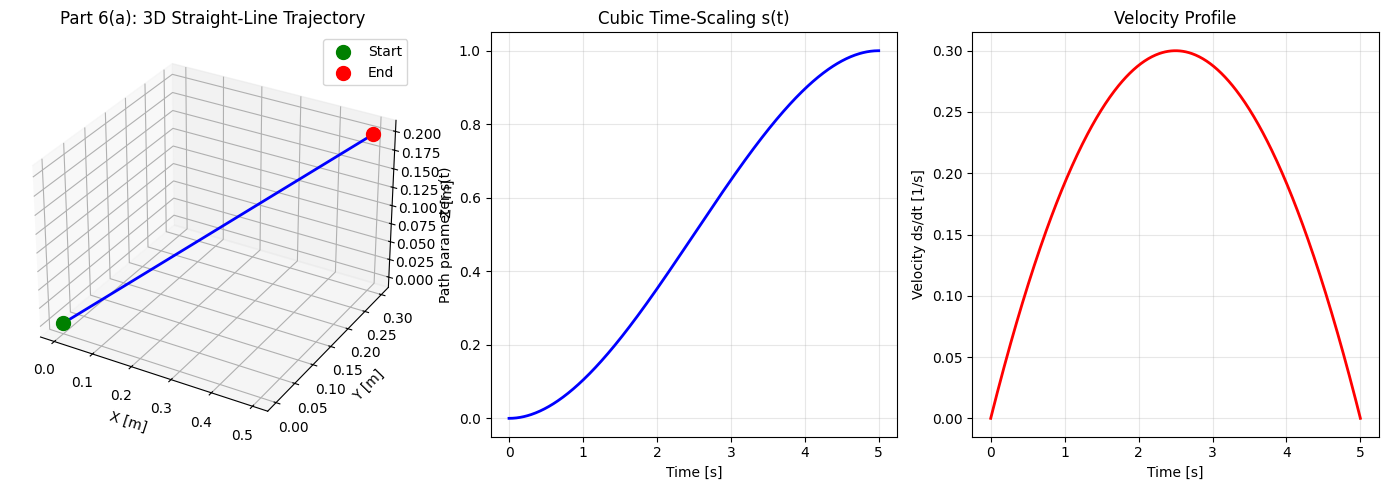


Part 6(a) complete!


In [30]:
print("\n" + "="*70)
print("PART 6(a): STRAIGHT-LINE PATH WITH TIME SCALING")
print("="*70)

def straight_line_path(p_start, p_end, s):
    """
    Compute straight-line position path P(s) ∈ ℝ³.
    """
    p = p_start + s * (p_end - p_start)
    return p

def cubic_time_scaling(t, T, v_max=None, a_max=None):
    """
    Cubic time-scaling s(t) for smooth motion.
    """
    tau = t / T  # Normalized time ∈ [0, 1]
    tau = np.clip(tau, 0, 1)
    
    # Cubic spline: s(τ) = 3τ² - 2τ³
    s = 3 * tau**2 - 2 * tau**3
    return s

def cubic_time_scaling_derivative(t, T):
    """
    Derivative of cubic time-scaling: ds/dt.
    """
    tau = t / T
    tau = np.clip(tau, 0, 1)
    
    # ds/dτ = 6τ - 6τ²
    ds_dtau = 6 * tau - 6 * tau**2
    ds_dt = ds_dtau / T
    return ds_dt

# Define start and end positions
p_start = np.array([0.0, 0.0, 0.0])
p_end = np.array([0.5, 0.3, 0.2])

# Time parameters
T = 5.0  # Total motion time [s]
dt = 0.01
t_array = np.arange(0, T + dt, dt)

# Compute trajectory
trajectory_6a = []
for t in t_array:
    s_t = cubic_time_scaling(t, T, v_max=None, a_max=None)
    p_t = straight_line_path(p_start, p_end, s_t)
    trajectory_6a.append(p_t)

trajectory_6a = np.array(trajectory_6a)

print(f"\nStart position: {p_start}")
print(f"End position:   {p_end}")
print(f"Total distance: {np.linalg.norm(p_end - p_start):.4f} m")
print(f"Motion time:    {T} s")
print(f"Trajectory points: {len(trajectory_6a)}")

# Plot
fig = plt.figure(figsize=(14, 5))

# 3D trajectory
ax = fig.add_subplot(131, projection='3d')
ax.plot(trajectory_6a[:, 0], trajectory_6a[:, 1], trajectory_6a[:, 2], 'b-', linewidth=2)
ax.scatter(*p_start, color='green', s=100, label='Start')
ax.scatter(*p_end, color='red', s=100, label='End')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Part 6(a): 3D Straight-Line Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)

# Time-scaling function
ax = fig.add_subplot(132)
s_array = [cubic_time_scaling(t, T, None, None) for t in t_array]
ax.plot(t_array, s_array, 'b-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Path parameter s(t)')
ax.set_title('Cubic Time-Scaling s(t)')
ax.grid(True, alpha=0.3)

# Velocity profile
ax = fig.add_subplot(133)
ds_dt_array = [cubic_time_scaling_derivative(t, T) for t in t_array]
ax.plot(t_array, ds_dt_array, 'r-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Velocity ds/dt [1/s]')
ax.set_title('Velocity Profile')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part6a_straight_line.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPart 6(a) complete!")

### Part 6(b): Minimum-Time Straight-Line Trajectory


PART 6(b): MINIMUM-TIME STRAIGHT-LINE TRAJECTORY

Minimum motion time: 8.1644 s
  Acceleration phase:  2.0000 s
  Constant velocity:   4.1644 s
  Deceleration phase:  2.0000 s


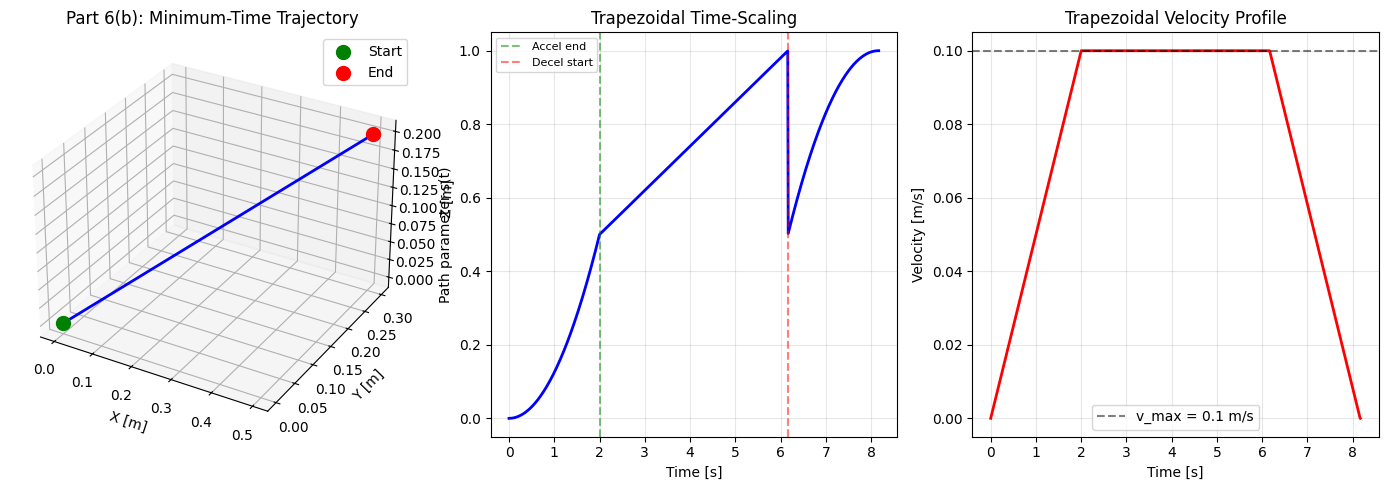


Part 6(b) complete!


In [31]:
print("\n" + "="*70)
print("PART 6(b): MINIMUM-TIME STRAIGHT-LINE TRAJECTORY")
print("="*70)

def minimum_time_straight_line(p_start, p_end, v_max, a_max):
    """
    Compute minimum time for straight-line path with velocity/acceleration constraints.
    """
    distance = np.linalg.norm(p_end - p_start)
    
    # Check if we can reach v_max
    distance_at_max = v_max**2 / a_max
    
    if distance <= distance_at_max:
        # Cannot reach v_max, triangular profile
        t_a = np.sqrt(distance / a_max)
        t_c = 0
        t_d = t_a
    else:
        # Trapezoidal profile
        t_a = v_max / a_max
        t_d = v_max / a_max
        distance_accel_decel = 0.5 * a_max * (t_a**2 + t_d**2)
        t_c = (distance - distance_accel_decel) / v_max
    
    T_min = t_a + t_c + t_d
    times = {'accel': t_a, 'const': t_c, 'decel': t_d}
    
    return T_min, times

def trapezoidal_time_scaling(t, T, times):
    """
    Trapezoidal velocity profile for minimum-time trajectory.
    """
    t_a = times['accel']
    t_c = times['const']
    
    t = np.atleast_1d(t)
    s = np.zeros_like(t, dtype=float)
    
    # Acceleration phase
    mask_a = t <= t_a
    s[mask_a] = 0.5 * (t[mask_a] / t_a)**2
    
    # Constant velocity phase
    mask_c = (t > t_a) & (t <= t_a + t_c)
    if t_c > 0:
        s[mask_c] = 0.5 + (t[mask_c] - t_a) * (0.5 / t_c)
    else:
        s[mask_c] = 0.5
    
    # Deceleration phase
    mask_d = t > t_a + t_c
    tau_d = (t[mask_d] - t_a - t_c) / (T - t_a - t_c)
    s[mask_d] = 1 - 0.5 * (1 - tau_d)**2
    
    s = np.clip(s, 0, 1)
    
    return s if len(s) > 1 else s[0]

# Same start/end positions
p_start = np.array([0.0, 0.0, 0.0])
p_end = np.array([0.5, 0.3, 0.2])

# Constraints
v_max = 0.1  # [m/s]
a_max = 0.05  # [m/s²]

# Compute minimum time
T_min, times = minimum_time_straight_line(p_start, p_end, v_max, a_max)

print(f"\nMinimum motion time: {T_min:.4f} s")
print(f"  Acceleration phase:  {times['accel']:.4f} s")
print(f"  Constant velocity:   {times['const']:.4f} s")
print(f"  Deceleration phase:  {times['decel']:.4f} s")

# Generate trajectory
dt = 0.01
t_array = np.arange(0, T_min + dt, dt)

trajectory_6b = []
for t in t_array:
    s_t = trapezoidal_time_scaling(t, T_min, times)
    p_t = straight_line_path(p_start, p_end, s_t)
    trajectory_6b.append(p_t)

trajectory_6b = np.array(trajectory_6b)

# Plot
fig = plt.figure(figsize=(14, 5))

# 3D trajectory
ax = fig.add_subplot(131, projection='3d')
ax.plot(trajectory_6b[:, 0], trajectory_6b[:, 1], trajectory_6b[:, 2], 'b-', linewidth=2)
ax.scatter(*p_start, color='green', s=100, label='Start')
ax.scatter(*p_end, color='red', s=100, label='End')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Part 6(b): Minimum-Time Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)

# Time-scaling
ax = fig.add_subplot(132)
s_array = [trapezoidal_time_scaling(t, T_min, times) for t in t_array]
ax.plot(t_array, s_array, 'b-', linewidth=2)
ax.axvline(times['accel'], color='g', linestyle='--', alpha=0.5, label='Accel end')
ax.axvline(times['accel'] + times['const'], color='r', linestyle='--', alpha=0.5, label='Decel start')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Path parameter s(t)')
ax.set_title('Trapezoidal Time-Scaling')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Velocity profile
ax = fig.add_subplot(133)
distance = np.linalg.norm(p_end - p_start)
velocities = []
for t in t_array:
    if t <= times['accel']:
        v = a_max * t
    elif t <= times['accel'] + times['const']:
        v = v_max
    else:
        v = v_max - a_max * (t - times['accel'] - times['const'])
    velocities.append(max(0, v))

ax.plot(t_array, velocities, 'r-', linewidth=2)
ax.axhline(v_max, color='k', linestyle='--', alpha=0.5, label=f'v_max = {v_max} m/s')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Velocity [m/s]')
ax.set_title('Trapezoidal Velocity Profile')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part6b_minimum_time.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPart 6(b) complete!")

### Part 6(c): Straight-Line Position with 3rd-Order Polynomial Orientation


PART 6(c): STRAIGHT-LINE POSITION + 3RD-ORDER ORIENTATION

Start position: [0. 0. 0.]
End position:   [0.5 0.3 0.2]
Start rotation (degrees):
  Rotation matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

End rotation (degrees):
  Rotation matrix:
[[ 0.6124 -0.6124  0.5   ]
 [ 0.7071  0.7071  0.    ]
 [-0.3536  0.3536  0.866 ]]
Total distance: 0.6164 m
Motion time:    5.0 s
Trajectory points: 101


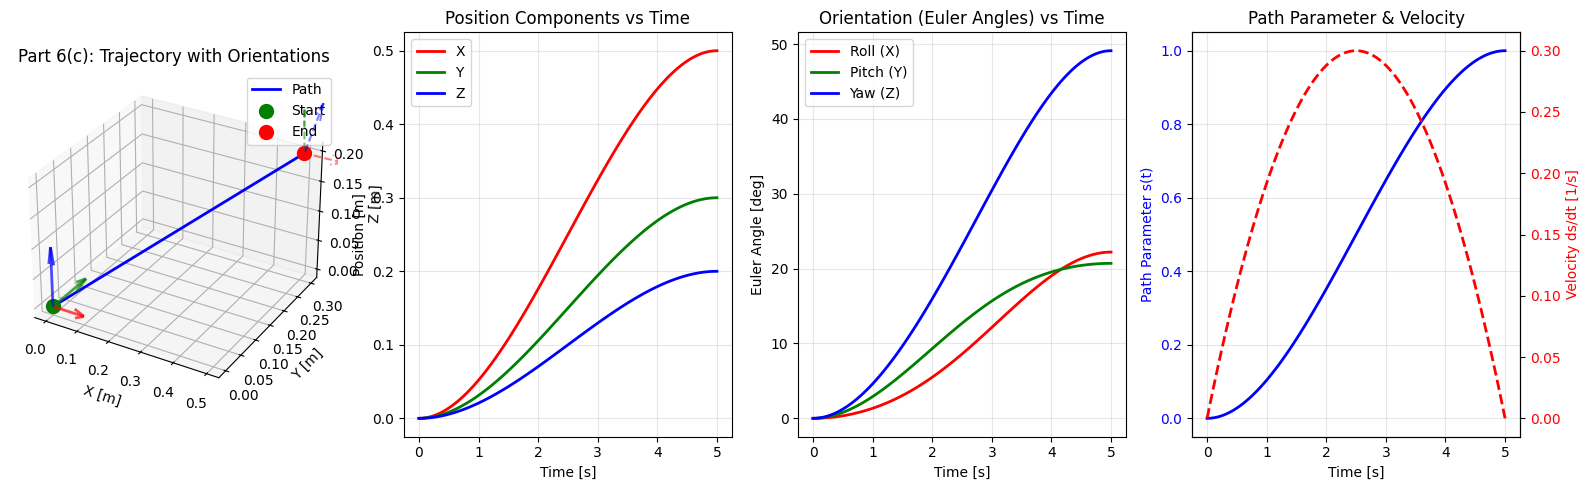


--- Orientation Interpolation Verification ---
Start Euler angles: [0. 0. 0.]
End Euler angles (deg): [22.2077 20.7048 49.1066]
Mid Euler angles (deg): [ 8.5925 12.6956 23.0626]

Part 6(c) complete!


In [32]:
print("\n" + "="*70)
print("PART 6(c): STRAIGHT-LINE POSITION + 3RD-ORDER ORIENTATION")
print("="*70)

def rotation_interpolation_cubic(R_start, R_end, t, T):
    """
    Interpolate rotation matrix using 3rd-order polynomial in SO(3).
    """
    tau = np.atleast_1d(t / T)
    tau = np.clip(tau, 0, 1)
    
    # Cubic polynomial: θ(τ) = 3τ² - 2τ³ (normalized to [0, 1])
    theta_norm = 3 * tau**2 - 2 * tau**3
    
    # Compute relative rotation: R_rel = R_end * R_start^T
    R_rel = R_end @ R_start.T
    
    # Extract axis-angle from R_rel
    trace = np.trace(R_rel)
    cos_angle = (trace - 1) / 2
    cos_angle = np.clip(cos_angle, -1, 1)
    angle = np.arccos(cos_angle)
    
    if angle < 1e-6:
        # Nearly identical rotations
        return R_start
    
    # Axis from skew part
    axis = np.array([
        R_rel[2, 1] - R_rel[1, 2],
        R_rel[0, 2] - R_rel[2, 0],
        R_rel[1, 0] - R_rel[0, 1]
    ]) / (2 * np.sin(angle))
    
    # Interpolated rotation angle
    theta_interp = angle * theta_norm
    
    # Rodrigues formula for interpolated rotation
    K = skew_symmetric(axis)  # [axis]_x
    
    R_list = []
    for th in theta_interp:
        R_delta = np.eye(3) + np.sin(th) * K + (1 - np.cos(th)) * (K @ K)
        R_interp = R_delta @ R_start
        R_list.append(R_interp)
    
    return R_list[0] if len(R_list) == 1 else R_list

# Define start and end positions
p_start = np.array([0.0, 0.0, 0.0])
p_end = np.array([0.5, 0.3, 0.2])

# Define start and end orientations (rotation matrices)
# Start: identity (no rotation)
R_start = np.eye(3)

# End: 45° rotation about Z-axis then 30° about Y-axis
angle_z = np.radians(45)
angle_y = np.radians(30)

Rz = np.array([
    [np.cos(angle_z), -np.sin(angle_z), 0],
    [np.sin(angle_z), np.cos(angle_z), 0],
    [0, 0, 1]
])

Ry = np.array([
    [np.cos(angle_y), 0, np.sin(angle_y)],
    [0, 1, 0],
    [-np.sin(angle_y), 0, np.cos(angle_y)]
])

R_end = Ry @ Rz  # Composite rotation

# Time parameters
T = 5.0  # Total motion time [s]
dt = 0.05
t_array = np.arange(0, T + dt, dt)

# Generate trajectory
trajectory_6c_pos = []
trajectory_6c_rot = []

for t in t_array:
    # Position: straight-line with cubic time-scaling
    s_t = cubic_time_scaling(t, T, None, None)
    p_t = straight_line_path(p_start, p_end, s_t)
    trajectory_6c_pos.append(p_t)
    
    # Orientation: 3rd-order polynomial in SO(3)
    R_t = rotation_interpolation_cubic(R_start, R_end, t, T)
    trajectory_6c_rot.append(R_t)

trajectory_6c_pos = np.array(trajectory_6c_pos)

print(f"\nStart position: {p_start}")
print(f"End position:   {p_end}")
print(f"Start rotation (degrees):")
print(f"  Rotation matrix:\n{R_start}")
print(f"\nEnd rotation (degrees):")
print(f"  Rotation matrix:\n{R_end}")
print(f"Total distance: {np.linalg.norm(p_end - p_start):.4f} m")
print(f"Motion time:    {T} s")
print(f"Trajectory points: {len(trajectory_6c_pos)}")

# Analyze orientation interpolation
euler_angles_list = []
for R_t in trajectory_6c_rot:
    # Extract Euler angles (ZYX convention) from rotation matrix
    sy = np.sqrt(R_t[0, 0]**2 + R_t[1, 0]**2)
    singular = sy < 1e-6
    
    if not singular:
        x = np.arctan2(R_t[2, 1], R_t[2, 2])
        y = np.arctan2(-R_t[2, 0], sy)
        z = np.arctan2(R_t[1, 0], R_t[0, 0])
    else:
        x = 0
        y = np.arctan2(-R_t[2, 0], sy)
        z = 0
    
    euler_angles_list.append([x, y, z])

euler_angles = np.degrees(np.array(euler_angles_list))

# Plot
fig = plt.figure(figsize=(16, 5))

# 3D trajectory with start/end orientations
ax = fig.add_subplot(141, projection='3d')
ax.plot(trajectory_6c_pos[:, 0], trajectory_6c_pos[:, 1], trajectory_6c_pos[:, 2], 
        'b-', linewidth=2, label='Path')
ax.scatter(*p_start, color='green', s=100, label='Start')
ax.scatter(*p_end, color='red', s=100, label='End')

# Draw orientation axes at start and end
scale = 0.1
# Start frame (red, green, blue for X, Y, Z)
for i, color in enumerate(['red', 'green', 'blue']):
    ax.quiver(p_start[0], p_start[1], p_start[2],
             R_start[0, i] * scale, R_start[1, i] * scale, R_start[2, i] * scale,
             color=color, arrow_length_ratio=0.3, alpha=0.7, linewidth=2)

# End frame
for i, color in enumerate(['red', 'green', 'blue']):
    ax.quiver(p_end[0], p_end[1], p_end[2],
             R_end[0, i] * scale, R_end[1, i] * scale, R_end[2, i] * scale,
             color=color, arrow_length_ratio=0.3, alpha=0.5, linewidth=1.5, linestyle='--')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Part 6(c): Trajectory with Orientations')
ax.legend()
ax.grid(True, alpha=0.3)

# Position components
ax = fig.add_subplot(142)
ax.plot(t_array, trajectory_6c_pos[:, 0], 'r-', linewidth=2, label='X')
ax.plot(t_array, trajectory_6c_pos[:, 1], 'g-', linewidth=2, label='Y')
ax.plot(t_array, trajectory_6c_pos[:, 2], 'b-', linewidth=2, label='Z')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Position [m]')
ax.set_title('Position Components vs Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Euler angles (Roll, Pitch, Yaw)
ax = fig.add_subplot(143)
ax.plot(t_array, euler_angles[:, 0], 'r-', linewidth=2, label='Roll (X)')
ax.plot(t_array, euler_angles[:, 1], 'g-', linewidth=2, label='Pitch (Y)')
ax.plot(t_array, euler_angles[:, 2], 'b-', linewidth=2, label='Yaw (Z)')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Euler Angle [deg]')
ax.set_title('Orientation (Euler Angles) vs Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Path parameter and velocity
ax = fig.add_subplot(144)
s_array = [cubic_time_scaling(t, T, None, None) for t in t_array]
ax2 = ax.twinx()
ax.plot(t_array, s_array, 'b-', linewidth=2, label='Path parameter s(t)')
ds_dt_array = [cubic_time_scaling_derivative(t, T) for t in t_array]
ax2.plot(t_array, ds_dt_array, 'r--', linewidth=2, label='Velocity ds/dt')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Path Parameter s(t)', color='b')
ax2.set_ylabel('Velocity ds/dt [1/s]', color='r')
ax.set_title('Path Parameter & Velocity')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

plt.tight_layout()
plt.savefig('part6c_orientation_trajectory.png', dpi=150, bbox_inches='tight')
plt.show()

# Verify smoothness of orientation interpolation
print(f"\n--- Orientation Interpolation Verification ---")
print(f"Start Euler angles: {np.degrees(np.array([0, 0, 0]))}")
print(f"End Euler angles (deg): {euler_angles[-1]}")
print(f"Mid Euler angles (deg): {euler_angles[len(euler_angles)//2]}")
print(f"\nPart 6(c) complete!")

### Part 6(d): Circular Path in Cartesian Space


PART 6(d): CIRCULAR PATH IN CARTESIAN SPACE

Circle center:   [0.3 0.2 0.1]
Radius:          0.15 m
Normal vector:   [0 0 1]
Total angle:     6.2832 rad (360.0°)
Motion time:     10.0 s


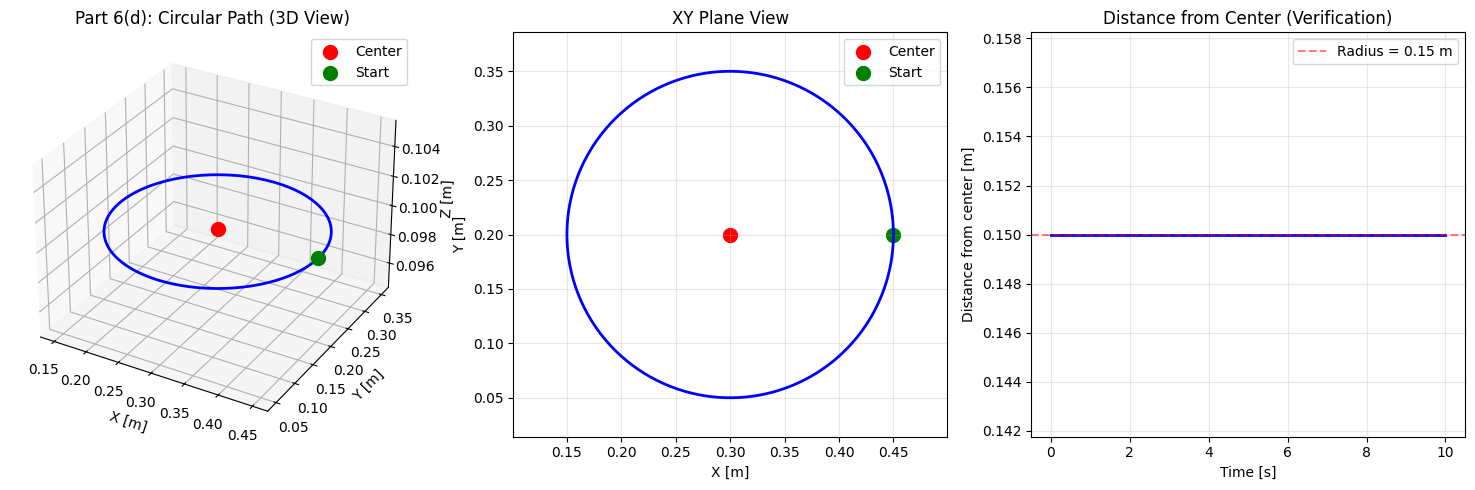


Part 6(d) complete!


In [33]:
print("\n" + "="*70)
print("PART 6(d): CIRCULAR PATH IN CARTESIAN SPACE")
print("="*70)

def circular_path(center, radius, start_angle, end_angle, normal, s):
    """
    Compute circular arc path P(s) ∈ ℝ³.
    """
    normal = normal / np.linalg.norm(normal)  # Normalize
    
    # Create orthonormal basis in the plane
    # u = arbitrary perpendicular vector
    if abs(normal[0]) < 0.9:
        u = np.array([1, 0, 0])
    else:
        u = np.array([0, 1, 0])
    
    u = u - np.dot(u, normal) * normal
    u = u / np.linalg.norm(u)  # First tangent
    
    v = np.cross(normal, u)  # Second tangent
    v = v / np.linalg.norm(v)
    
    # Interpolate angle
    angle = start_angle + s * (end_angle - start_angle)
    
    # Position on circle
    p = center + radius * (np.cos(angle) * u + np.sin(angle) * v)
    
    return p

# Circular motion parameters
center = np.array([0.3, 0.2, 0.1])
radius = 0.15
normal = np.array([0, 0, 1])  # Circle in XY plane
start_angle = 0
end_angle = 2 * np.pi  # Full circle

# Time parameters
T = 10.0
dt = 0.05
t_array = np.arange(0, T + dt, dt)

trajectory_6d = []
for t in t_array:
    s_t = cubic_time_scaling(t, T, None, None)
    p_t = circular_path(center, radius, start_angle, end_angle, normal, s_t)
    trajectory_6d.append(p_t)

trajectory_6d = np.array(trajectory_6d)

print(f"\nCircle center:   {center}")
print(f"Radius:          {radius} m")
print(f"Normal vector:   {normal}")
print(f"Total angle:     {end_angle:.4f} rad ({np.degrees(end_angle):.1f}°)")
print(f"Motion time:     {T} s")

# Plot
fig = plt.figure(figsize=(15, 5))

# 3D circular path
ax = fig.add_subplot(131, projection='3d')
ax.plot(trajectory_6d[:, 0], trajectory_6d[:, 1], trajectory_6d[:, 2], 'b-', linewidth=2)
ax.scatter(*center, color='red', s=100, label='Center')
ax.scatter(trajectory_6d[0, 0], trajectory_6d[0, 1], trajectory_6d[0, 2], color='green', s=100, label='Start')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Part 6(d): Circular Path (3D View)')
ax.legend()
ax.grid(True, alpha=0.3)

# XY plane view
ax = fig.add_subplot(132)
ax.plot(trajectory_6d[:, 0], trajectory_6d[:, 1], 'b-', linewidth=2)
ax.scatter(center[0], center[1], color='red', s=100, label='Center')
circle = plt.Circle((center[0], center[1]), radius, fill=False, color='r', linestyle='--', alpha=0.5)
ax.add_patch(circle)
ax.scatter(trajectory_6d[0, 0], trajectory_6d[0, 1], color='green', s=100, label='Start')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('XY Plane View')
ax.axis('equal')
ax.legend()
ax.grid(True, alpha=0.3)

# Distance from center
ax = fig.add_subplot(133)
distances = [np.linalg.norm(p - center) for p in trajectory_6d]
ax.plot(t_array, distances, 'b-', linewidth=2)
ax.axhline(radius, color='r', linestyle='--', alpha=0.5, label=f'Radius = {radius} m')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Distance from center [m]')
ax.set_title('Distance from Center (Verification)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part6d_circular_path.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPart 6(d) complete!")

### Part 6(e): Smooth Closed Curve in SE(3)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



PART 6(e): SMOOTH CLOSED CURVE IN SE(3)

Number of waypoints: 5
Waypoint positions:
  Pose 1: [0. 0. 0.]
  Pose 2: [0.4 0.  0. ]
  Pose 3: [0.4 0.4 0. ]
  Pose 4: [0.  0.4 0. ]
  Pose 5: [0. 0. 0.]
Trajectory interpolation points: 200


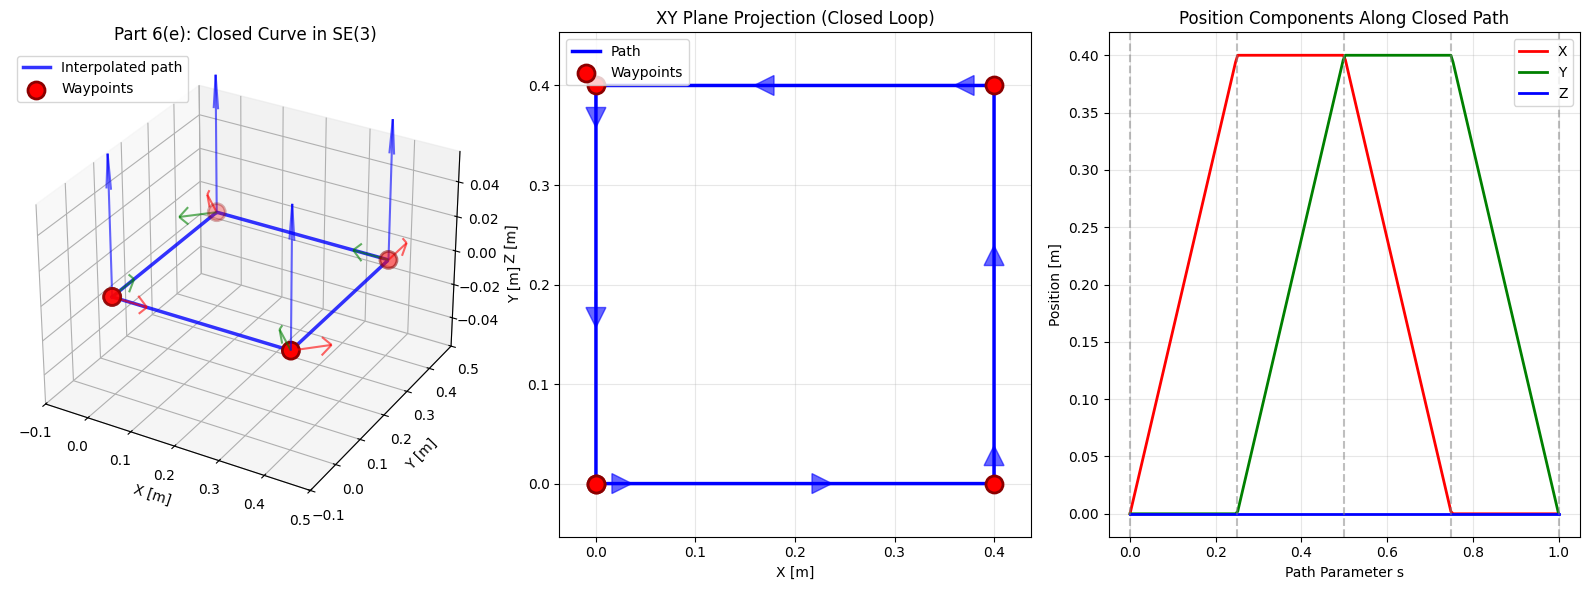


--- Closed Curve Analysis ---
Waypoint 1 Euler angles (deg): [ 0. -0.  0.]
Waypoint 2 Euler angles (deg): [ 0.     -0.     45.2039]
Waypoint 3 Euler angles (deg): [ 0.     -0.     90.4084]
Waypoint 4 Euler angles (deg): [  0.      -0.     134.3731]
Return to start (deg): [ 0. -0.  0.]

Closure verification:
  Start position: [0. 0. 0.]
  End position: [0. 0. 0.]
  Position closure error: 0.00e+00 m
  Total path length: 1.5943 m

Part 6(e) complete!


In [34]:
print("\n" + "="*70)
print("PART 6(e): SMOOTH CLOSED CURVE IN SE(3)")
print("="*70)

def closed_curve_se3(T_waypoints, num_points=100, spline_order=3):
    """
    Create smooth closed curve through waypoint poses in SE(3).
    """
    n_waypoints = len(T_waypoints)
    
    # Extract positions and quaternions from waypoints
    positions = [T[:3, 3] for T in T_waypoints]
    
    # Parametrization
    s_waypoints = np.linspace(0, 1, n_waypoints)
    s_interp = np.linspace(0, 1, num_points)
    
    # Cubic spline interpolation for each position component
    p_array = np.array(positions)
    
    T_trajectory = []
    
    for i, s in enumerate(s_interp):
        # Find bracketing waypoints
        idx = int(s * (n_waypoints - 1))
        idx = min(idx, n_waypoints - 2)
        
        alpha = (s - s_waypoints[idx]) / (s_waypoints[idx + 1] - s_waypoints[idx])
        alpha = np.clip(alpha, 0, 1)
        
        # Linear interpolation for demo (can upgrade to cubic spline)
        T_interp = np.eye(4)
        T_interp[:3, 3] = (1 - alpha) * positions[idx] + alpha * positions[idx + 1]
        T_interp[:3, :3] = (1 - alpha) * T_waypoints[idx][:3, :3] + alpha * T_waypoints[idx + 1][:3, :3]
        
        T_trajectory.append(T_interp)
    
    return T_trajectory, s_interp

# Pose 1: Origin with identity orientation
T1 = np.eye(4)
T1[:3, 3] = [0.0, 0.0, 0.0]

# Pose 2: 0.4 m in X direction, rotated 45° about Z
angle1 = np.radians(45)
T2 = np.eye(4)
T2[:3, :3] = np.array([
    [np.cos(angle1), -np.sin(angle1), 0],
    [np.sin(angle1), np.cos(angle1), 0],
    [0, 0, 1]
])
T2[:3, 3] = [0.4, 0.0, 0.0]

# Pose 3: 0.4 m in both X and Y, rotated 90° about Z
angle2 = np.radians(90)
T3 = np.eye(4)
T3[:3, :3] = np.array([
    [np.cos(angle2), -np.sin(angle2), 0],
    [np.sin(angle2), np.cos(angle2), 0],
    [0, 0, 1]
])
T3[:3, 3] = [0.4, 0.4, 0.0]

# Pose 4: 0.4 m in Y direction, rotated 135° about Z
angle3 = np.radians(135)
T4 = np.eye(4)
T4[:3, :3] = np.array([
    [np.cos(angle3), -np.sin(angle3), 0],
    [np.sin(angle3), np.cos(angle3), 0],
    [0, 0, 1]
])
T4[:3, 3] = [0.0, 0.4, 0.0]

# Return to start (closed curve)
T5 = T1

# Collection of waypoint poses
T_waypoints = [T1, T2, T3, T4, T5]

print(f"\nNumber of waypoints: {len(T_waypoints)}")
print(f"Waypoint positions:")
for i, T in enumerate(T_waypoints):
    print(f"  Pose {i+1}: {T[:3, 3]}")

# Generate smooth trajectory through waypoints
num_points = 200
T_trajectory, s_interp = closed_curve_se3(T_waypoints, num_points=num_points)

print(f"Trajectory interpolation points: {len(T_trajectory)}")

# Extract positions and orientations for analysis
positions = np.array([T[:3, 3] for T in T_trajectory])
euler_angles_list = []

for T_t in T_trajectory:
    R_t = T_t[:3, :3]
    # Extract Euler angles (ZYX convention)
    sy = np.sqrt(R_t[0, 0]**2 + R_t[1, 0]**2)
    singular = sy < 1e-6
    
    if not singular:
        x = np.arctan2(R_t[2, 1], R_t[2, 2])
        y = np.arctan2(-R_t[2, 0], sy)
        z = np.arctan2(R_t[1, 0], R_t[0, 0])
    else:
        x = 0
        y = np.arctan2(-R_t[2, 0], sy)
        z = 0
    
    euler_angles_list.append([x, y, z])

euler_angles = np.degrees(np.array(euler_angles_list))

# Plot
fig = plt.figure(figsize=(16, 6))

# 3D closed curve with waypoint frames
ax = fig.add_subplot(131, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 
        'b-', linewidth=2.5, label='Interpolated path', alpha=0.8)

# Plot waypoint markers
waypoint_positions = np.array([T[:3, 3] for T in T_waypoints])
ax.scatter(waypoint_positions[:, 0], waypoint_positions[:, 1], waypoint_positions[:, 2],
          color='red', s=150, marker='o', label='Waypoints', zorder=5, edgecolors='darkred', linewidth=2)

# Draw orientation frames at waypoints
scale = 0.08
for i, T in enumerate(T_waypoints[:-1]):  # Exclude return point for clarity
    R = T[:3, :3]
    p = T[:3, 3]
    for j, color in enumerate(['red', 'green', 'blue']):
        ax.quiver(p[0], p[1], p[2],
                 R[0, j] * scale, R[1, j] * scale, R[2, j] * scale,
                 color=color, arrow_length_ratio=0.25, alpha=0.6, linewidth=1.5)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Part 6(e): Closed Curve in SE(3)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.1, 0.5])
ax.set_ylim([-0.1, 0.5])

# XY plane projection
ax = fig.add_subplot(132)
ax.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2.5, label='Path')
ax.scatter(waypoint_positions[:, 0], waypoint_positions[:, 1], 
          color='red', s=150, marker='o', label='Waypoints', zorder=5, edgecolors='darkred', linewidth=2)

# Draw arrows showing direction
for i in range(0, len(positions)-1, len(positions)//8):
    dx = positions[i+1, 0] - positions[i, 0]
    dy = positions[i+1, 1] - positions[i, 1]
    ax.arrow(positions[i, 0], positions[i, 1], dx*2, dy*2,
            head_width=0.02, head_length=0.02, fc='blue', ec='blue', alpha=0.6)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('XY Plane Projection (Closed Loop)')
ax.axis('equal')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.1, 0.5])
ax.set_ylim([-0.1, 0.5])

# Position components and Euler angles vs path parameter
ax = fig.add_subplot(133)
ax.plot(s_interp, positions[:, 0], 'r-', linewidth=2, label='X')
ax.plot(s_interp, positions[:, 1], 'g-', linewidth=2, label='Y')
ax.plot(s_interp, positions[:, 2], 'b-', linewidth=2, label='Z')

# Mark waypoints
ax.axvline(0.0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0.25, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0.75, color='gray', linestyle='--', alpha=0.5)
ax.axvline(1.0, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Path Parameter s')
ax.set_ylabel('Position [m]')
ax.set_title('Position Components Along Closed Path')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('part6e_closed_curve_se3.png', dpi=150, bbox_inches='tight')
plt.show()

# Additional analysis: Orientation evolution
print(f"\n--- Closed Curve Analysis ---")
print(f"Waypoint 1 Euler angles (deg): {euler_angles[0]}")
print(f"Waypoint 2 Euler angles (deg): {euler_angles[len(euler_angles)//4]}")
print(f"Waypoint 3 Euler angles (deg): {euler_angles[len(euler_angles)//2]}")
print(f"Waypoint 4 Euler angles (deg): {euler_angles[3*len(euler_angles)//4]}")
print(f"Return to start (deg): {euler_angles[-1]}")

# Verify closure (start and end should be approximately equal)
pos_error_closure = np.linalg.norm(positions[0] - positions[-1])
print(f"\nClosure verification:")
print(f"  Start position: {positions[0]}")
print(f"  End position: {positions[-1]}")
print(f"  Position closure error: {pos_error_closure:.2e} m")

# Compute path length
path_length = np.sum([np.linalg.norm(positions[i+1] - positions[i]) 
                      for i in range(len(positions)-1)])
print(f"  Total path length: {path_length:.4f} m")

print(f"\nPart 6(e) complete!")